<a href="https://colab.research.google.com/github/ekrell/ams_ai_shortcourse_2024/blob/main/modules/xai_raster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course: Intro to XAI

**Part 2
: Raster Models**

This Colab Notebook demonstrates using XAI methods to explain multi-channel raster models.

While many XAI methods support explaining RGB and grayscale images, they very often do not support raster data with an arbitrary number of channels. These are very common in atmospheric and geoscience modeling applications.

**Examples:**
- [Hilburn et al., GOES satellite data](https://journals.ametsoc.org/view/journals/apme/60/1/jamc-d-20-0084.1.xml)
- [Lagerquist et al., 48 channels of NWP & reanalysis data](https://shareok.org/handle/11244/324145)
- [Kamangir et al., 384 channels of NWP & satellite data](https://www.sciencedirect.com/science/article/pii/S2666827021000190)

**Dataset**

**From:** [Machine Learning in Python for Environmental Science Problems AMS Short Course Material](https://github.com/djgagne/ams-ml-python-course) by [David John Gagne](https://staff.ucar.edu/users/dgagne)

**Notebook borrows code from:** [Ryan Lagerquist's AI2ES/CIRA short course on XAI for Environmental science](https://docs.google.com/document/d/1lqpABwDl3kPe6ThE-NIDR64PimnltJEuKNkysDZuWKQ/edit)

 - Lecture 3 performs XAI on same model & data, but using other techniques. Recommend it to see even more XAI methods.

**Goal:**

- Given:
  - simulated radar reflectivity > 40 dBZ
  - associated surface wind & temperature fields
- Predict: probability of low-level vorticity exceeding a certain threshold

**Input feature maps (raster channels):**

- `REFL_COM_curr` (composite reflectivity)
- `U10_curr` (10 m west-east wind component in m/s)
- `V10_curr` (10 m south-north wind component in m/s)
- `T2_curr` (2 m temperature in Kelvin)

**Prediction target:**

- `RVORT1_MAX_future` (hourly maximum vertical vorticity at 1 km Above ground level in s-1)



**XAI Methods:**

- Occlusion Saliency Maps
- Channel-wise PartitionSHAP

# Dataset & Model

**The following installation requires restarting the session, so it placed as the first code block**

In [ ]:
# A fork of the SHAP library with contains Channel-wise PartitionSHAP
!pip install git+https://github.com/conrad-blucher-institute/shap.git
import shap

!pip install descarteslabs[complete]
!pip install descartes
import descartes

  Cloning https://github.com/conrad-blucher-institute/shap.git to /tmp/pip-req-build-t9wws4ey
  Running command git clone --filter=blob:none --quiet https://github.com/conrad-blucher-institute/shap.git /tmp/pip-req-build-t9wws4ey
  Resolved https://github.com/conrad-blucher-institute/shap.git to commit c78a7a625eccc892c716f402e81ca8ef01156747
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

**Setup environment**

In [ ]:
# Pre-trained model
cnn_file_name = '/content/course_repository/pretrained_cnn/model.h5'

# Data
LOCAL_DIRECTORY_NAME = 'data'
ONLINE_IMAGE_FILE_NAME = (
    'https://storage.googleapis.com/track_data_ncar_ams_3km_nc_small/'
    'track_data_ncar_ams_3km_nc_small.tar.gz'
)

# Cached XAI outputs
ONLINE_XAI_FILE_NAMES = [
    "https://drive.google.com/file/d/1GpRG2IYnYD9-xh1OP3LAWR70hncOcSNg/view?usp=sharing",
    ""
]

**Install packages**

In [ ]:
# Install Ryan Lagerquist's AI2ES short course repo
!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
!cd course_repository; python setup.py install

# Add directories to python path
import sys
sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

fatal: destination path 'course_repository' already exists and is not an empty directory.
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
    

**Import libraries**

In [ ]:
# General packages
import os
import sys
import shutil
import errno
import tarfile
import time
import copy
import glob
import os.path
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

# Packages from Ryan Lagerquist's AI2ES short course repo
from ai2es_xai_course.plotting import image_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding

**Definitions**

In [ ]:
# Date formats
# DATE_FORMAT = '%Y%m%d'
# DATE_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9]'

# Predictor names
PREDICTOR_NAMES = ['reflectivity_dbz', 'temperature_kelvins',
                   'u_wind_m_s01', 'v_wind_m_s01' ]

# Target name
TARGET_NAME = 'max_future_vorticity_s01'

**Load pretrained CNN**

In [ ]:
cnn_model_object = utils.read_dense_net(cnn_file_name)

Instructions for updating:
Colocations handled automatically by placer.


**Download data**

In [ ]:
# Make directory for storm data
try:
  os.makedirs(LOCAL_DIRECTORY_NAME)
except:
  pass

# Download storm data
t0 = time.time()
local_image_file_name = '{0:s}/{1:s}'.format(
        LOCAL_DIRECTORY_NAME, os.path.split(ONLINE_IMAGE_FILE_NAME)[-1]
    )
print('Downloading data to: "{0:s}"...'.format(local_image_file_name))
urlretrieve(ONLINE_IMAGE_FILE_NAME, local_image_file_name)
print('Unzipping file: "{0:s}"...'.format(local_image_file_name))
tar_file_handle = tarfile.open(local_image_file_name)
tar_file_handle.extractall(LOCAL_DIRECTORY_NAME)
tar_file_handle.close()
print("Downloaded and unzipped in {} seconds".format(time.time() - t0))


Unzipping file: "data/track_data_ncar_ams_3km_nc_small.tar.gz"...
Downloaded and unzipped in 38.09728527069092 seconds


In [ ]:
local_image_directory = '{0:s}/{1:s}/'.format(
        LOCAL_DIRECTORY_NAME, os.path.split(ONLINE_IMAGE_FILE_NAME)[-1].split(".")[0]
    )

# create a list of the files and print it out
files = sorted(glob.glob(local_image_directory+"/*.nc"))

print("Found {} netCDF files: ".format(len(files)))

Found 100 netCDF files: 


**Extreme cases**

The following are list of indices of four extreme cases.

For example, `worst_false_alarms` contains the cases where the model was most sure of a positive identification, when there in fact was none.

In [ ]:
best_hit_indices = np.array([ \
       10451, 13350,  5749, 14659, 13250,  2687,  6845,  6846,  6847,
        6848, 10642, 10643,  2731, 15811,  2767,  7080, 14515,  7121,
        7122,  9649,  7151,  7153, 10690, 14457,  9533,  4107,  3179,
       16315, 14660, 13363,  2806, 10449, 10450, 13614,  5912, 13552,])

worst_false_alarm_indices = np.array([ \
        6356, 13798,  6389,  6125,  5721, 14518,  6914, 15991, 18755,
        5568,  9436,  1892, 11716,  6851, 13802, 13468,  5638, 12719,
       13831, 13370, 15542, 15681,  3188, 13457, 12909, 16284,  9788,
        8477, 15919, 12479,  6514,  9331, 13361, 12218,  6294, 17583,])

worst_miss_indices = np.array([
       18112,  8894, 17333,  8671, 12419,   468,  5235,   831,  7998,
       18108,   671,  1568,   328,   529, 14525, 17511, 17513, 17209,
        5011, 17378,   536, 10379, 16604, 17474, 11988,  2355,   602,
        1650, 14770, 18991, 10539,  2177, 19151,   454,   537,  1331,])

best_correct_null_indices = np.array([
       17862, 17755, 18009, 18006, 17914, 16781, 17874, 15880, 16820,
         589, 16780, 18080,  2608, 18008, 18003, 15703, 17839, 18000,
       17829, 17857, 18219, 17957,  2811, 15881, 18004, 16737, 16302,
       18007,  1761,  3255, 16104,   588, 17860, 15753,  1477, 16305,])

**Get metadata**

In [ ]:
# Get an arbitrary file
netcdf_file = files[0]

# File: extract relative path
netcdf_file_name = netcdf_file.split("/")[-1]

# Read as dictionary
storm_data = image_utils.read_file("{}/{}".format(local_image_directory, netcdf_file_name))

feature_names = storm_data['predictor_names']
E = storm_data['storm_id_nums'].shape[0]
Euniq = len(np.unique(storm_data['storm_id_nums']))
M, N, C = storm_data['predictor_matrix'][0].shape

print("Storm data keys:")
print(storm_data.keys())

print("\n")
print("Predictor raster shape:")
print("  Number of storm objects (E):                   {}".format(E))
print("     Unique storm objects    :                   {}".format(Euniq))
print("  Number of feature maps  (C):                   {}".format(C))
print("  Shape of each storm object raster (M, N, C):   {} x {} x {}".format(M, N, C))

print("\n")
print("Predictor feature map names:")
print(storm_data["predictor_names"])

print("\n")
print("Target name:", storm_data["target_name"])

print("Target raster shape:")
print("  Number of targets: {}".format(storm_data["target_matrix"].shape[0]))
print("  Shape of each target raster: {} x {}".format(storm_data["target_matrix"].shape[1], storm_data["target_matrix"].shape[2]))

storm_array = storm_data['predictor_matrix'][0]


Storm data keys:
dict_keys(['storm_id_nums', 'storm_steps', 'predictor_names', 'predictor_matrix', 'target_name', 'target_matrix'])


Predictor raster shape:
  Number of storm objects (E):                   1472
     Unique storm objects    :                   775
  Number of feature maps  (C):                   4
  Shape of each storm object raster (M, N, C):   32 x 32 x 4


Predictor feature map names:
['reflectivity_dbz', 'temperature_kelvins', 'u_wind_m_s01', 'v_wind_m_s01']


Target name: max_future_vorticity_s01
Target raster shape:
  Number of targets: 1472
  Shape of each target raster: 32 x 32


**Plotting utilities**

In [ ]:
def plot_storm_array(predictor_matrix, labels, contour=False):
    """Plots each channel of a storm-centered raster loaded from NetCDF file.
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param labels: C-length list of feature names to label each output.
  """

    fig, ax = plt.subplots(1, len(labels), figsize=(15, 3))
    for i in range(len(labels)):

        # Contour plot
        if contour:
          ax[i].contour(predictor_matrix[:,:,i])

        # Image plot
        else:
          ax[i].imshow(predictor_matrix[:,:,i])
          ax[i].invert_yaxis()

        ax[i].set_title(labels[i])
        ax[i].axis('off')

**Plot a single raster sample**

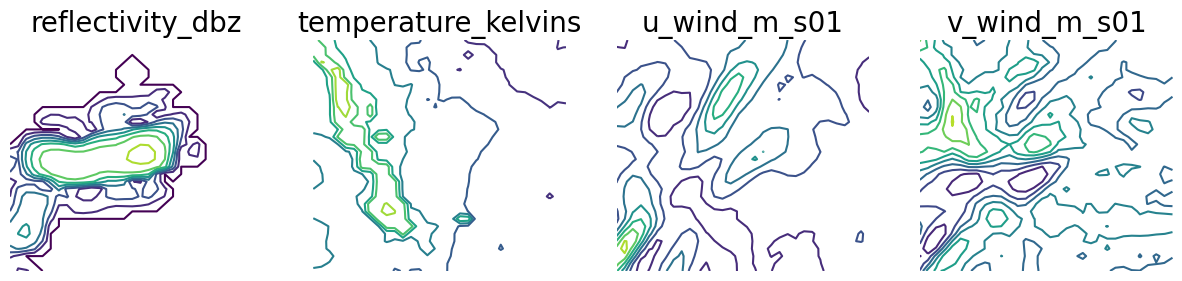

In [ ]:
plot_storm_array(storm_array, labels=feature_names, contour=True)

**Load test dataset**

In [ ]:
# Get list of test data files
image_testing_file_names = image_utils.find_many_files(
    first_date_string='20160101', last_date_string='20171231',
    directory_name=local_image_directory)

# Read all into dictionary
testing_image_dict = image_utils.read_many_files(image_testing_file_names)

# For simplicity, rename to `data`
data = testing_image_dict

Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160224-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160323-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160401-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160415-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160429-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160505-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160511-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160522-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20160528-0000_d01_model_patches.nc"...
Reading data from: "data/track_data_n

**Data processing**

- **Normalization parameters:**
  - mean & standard deviation of each feature map

In [ ]:
# Calculate normalization parameters
image_normalization_dict = image_normalization.get_normalization_params(image_dict=data)
print("Feature map normalization parameters:")
for key in image_normalization_dict.keys():
  print("  {}: \t(mean = {:.4f}, std. dev. = {:.4f})".format(key,
      image_normalization_dict[key][0], image_normalization_dict[key][1]) )

Feature map normalization parameters:
  reflectivity_dbz: 	(mean = 22.9374, std. dev. = 15.7897)
  temperature_kelvins: 	(mean = 289.7109, std. dev. = 7.9631)
  u_wind_m_s01: 	(mean = -0.6065, std. dev. = 4.5111)
  v_wind_m_s01: 	(mean = 0.5095, std. dev. = 5.2641)


In [ ]:
# Unnormalized & normalized versions of the rasters

# Original: used to plot the input raster
predictor_matrix_denorm = data[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = data[image_utils.PREDICTOR_NAMES_KEY]

# Normalized: used as input to model
predictor_matrix_norm = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

**Evaluate model using test data**

- `RVORT1_MAX_future` (hourly maximum vertical vorticity at 1 km Above ground level in s-1)

In [ ]:
# Predict the first 5
preds = cnn_model_object.predict(predictor_matrix_norm[0][0:5,:])
print(preds)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


[[0.1550841 ]
 [0.00978116]
 [0.01331778]
 [0.06138797]
 [0.03611452]]


In [ ]:
# Simplified model evaluation function (easier to pass to XAI methods)
def m(X):
  return cnn_model_object.predict(X)

## Organize test samples by outcome classes

In [ ]:
# Best hits
best_hits_matrix_denorm = predictor_matrix_denorm[best_hit_indices]
best_hits_matrix_norm = (
    predictor_matrix_norm[0][best_hit_indices],
    predictor_matrix_norm[1]
)

# Worst false alarms
worst_false_alarm_matrix_denorm = predictor_matrix_denorm[worst_false_alarm_indices]
worst_false_alarm_matrix_norm = (
    predictor_matrix_norm[0][worst_false_alarm_indices],
    predictor_matrix_norm[1]
)

# Worst misses
worst_miss_matrix_denorm = predictor_matrix_denorm[worst_miss_indices]
worst_miss_matrix_norm = (
    predictor_matrix_norm[0][worst_miss_indices],
    predictor_matrix_norm[1]
)

# Best correst nulls
best_correct_null_matrix_denorm = predictor_matrix_denorm[best_correct_null_indices]
best_correct_null_matrix_norm = (
    predictor_matrix_norm[0][best_correct_null_indices],
    predictor_matrix_norm[1]
)

**Probability-Matched Means (PMM)-based Input Aggregates**

- Use PMM to create aggregates of the four outcome types
- That is, the PMM _Best Hit_ captures an average _Best Hit_
- Used for summary (aggregate) explanations of the _Best Hit_ in general (and the other 3 outcome types)


In [ ]:
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[best_correct_null_indices])

**Min & max of each variable for consistent plot colors**

In [ ]:
# Combine all extreme cases
concat_predictor_matrix = np.stack((
    best_hits_matrix_denorm, worst_false_alarm_matrix_denorm,
    worst_miss_matrix_denorm, best_correct_null_matrix_denorm,
), axis=0)

# Temperature: find 1-th prctle & 99th prctile across all above cases
temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = np.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = np.percentile(temperature_matrix_kelvins, 99)

# Wind speed: find 99th prctile across all above cases
max_speed_m_s01 = np.percentile(
    np.absolute(concat_predictor_matrix[..., 2:4]), 99
)

# Feature Effect Methods

## Occlusion Sensitivity Maps

- A super-simple method that illustrates basic XAI concepts
- Unlike others shown, so simple that the whole algorithm is defined below

**Concept:**
- If a region of pixels is important, then output should change if that region becomes something else
- But single-pixel changes may not be well-suited to models such as CNNs that learn patterns (e.g. textures) that involve a neighborhood of pixels
- So, we move a window across the image to replace values

**Caveats:**
- We don't know the best window size
- We don't know the best replacement values
  - Replace with 0?
  - Blur the pixels in the window?
- We simulate feature removal, but actually create unrealistic, out-of-sample inputs
- The model may rely on irregular shapes or even distant pixels

**This is a simple version of the algorithm to give a basic sense of XAI methds. There is a more fully-featured implementation available by [Ryan Lagerquist](https://github.com/thunderhoser/ai2es_xai_course/blob/main/ai2es_xai_course/utils/occlusion.py).**


> Occlusion Sensitivity approach also performs well across all quality measurements.... Another big upside is the quickness of the algorithm.  
[[Benedikt Limmer, 2020]](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiz3sPBodGDAxXQmGoFHc7_A3wQFnoECBUQAQ&url=https%3A%2F%2Fopus.bibliothek.uni-augsburg.de%2Fopus4%2Ffrontdoor%2Fdeliver%2Findex%2FdocId%2F82118%2Ffile%2FExplainable_AI_Bachelorarbeit.pdf&usg=AOvVaw2YBG-MRQSKNTRghF-w1HiH&opi=89978449)  


Occlusion functions are modified from [
RaphaelMeudec's `occlusion_sensitivity.py`
](https://gist.github.com/RaphaelMeudec/7985b0c5eb720a29021d52b0a0be549a)

In [ ]:
# Create function to apply a white patch on an image
def apply_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 0
    return patched_image

def occlusion(img, model, patch_size=2, class_idx=0):
  sensitivity_map = np.zeros((img.shape[0], img.shape[1]))
  original_prob = predicted_classes = model.predict(np.array([img]))[0]

  # Iterate the patch over the image
  for top_left_x in range(0, img.shape[1], patch_size):
      for top_left_y in range(0, img.shape[0], patch_size):

          patched_image = apply_patch(img, top_left_x, top_left_y, patch_size)
          predicted_classes = model.predict(np.array([patched_image]))[0]
          confidence = predicted_classes[class_idx]
          diff = original_prob - confidence

          # Save confidence for this specific patched image in map
          sensitivity_map[
              top_left_y:top_left_y + patch_size,
              top_left_x:top_left_x + patch_size,
          ] = diff

  return sensitivity_map

In [ ]:
# Get some samples
X = best_hits_matrix_norm[0][0:5,:]

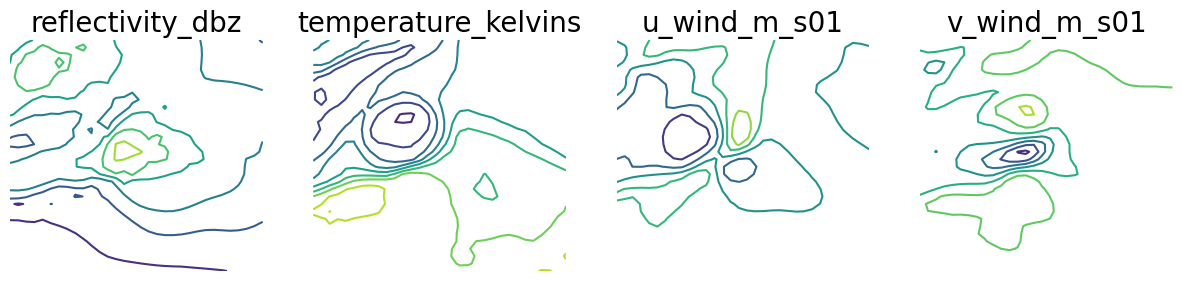

In [ ]:
plot_storm_array(X[0], labels=feature_names, contour=True)

In [ ]:
# Generate 3 occlusion maps with different patch sizes
occmap_2 = occlusion(X[0], cnn_model_object, patch_size = 2)
occmap_4 = occlusion(X[0], cnn_model_object, patch_size = 4)
occmap_8 = occlusion(X[0], cnn_model_object, patch_size = 8)

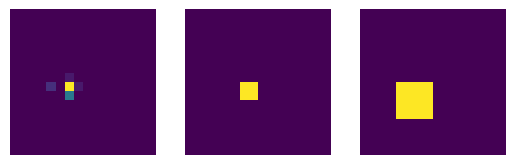

In [ ]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(occmap_2)
axs[1].imshow(occmap_4)
axs[2].imshow(occmap_8)

# Remove distracting axis labels
for ax in axs:
  ax.set_axis_off()
  ax.invert_yaxis()

**Single-channel Occlusion Maps?**

- Occlusion Map highlights the center of the image
- Which is not too surprising since these are storm-centered images
- But we really need 4 occlusion maps based on occluding each channel at a time

**Multi-channel Occlusion Maps**

(Note: it is better to have a single function that supports either single or multi channel. This is just for illustration)

In [ ]:
# Create function to apply a white patch on an image
def apply_patch_multichannel(image, top_left_x, top_left_y, patch_size, band):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, band] = 0
    return patched_image

def occlusion_multichannel(img, model, patch_size=2, class_idx=0):
  sensitivity_map = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
  original_prob = predicted_classes = model.predict(np.array([img]))[0]

  # Iterate the patch over the image
  for band in range(img.shape[2]):
    for top_left_x in range(0, img.shape[0], patch_size):
        for top_left_y in range(0, img.shape[1], patch_size):

            patched_image = apply_patch_multichannel(img, top_left_x, top_left_y, patch_size, band)
            predicted_classes = model.predict(np.array([patched_image]))[0]
            confidence = predicted_classes[class_idx]
            diff = original_prob - confidence

            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + patch_size,
                top_left_x:top_left_x + patch_size,
                band
            ] = diff

  return sensitivity_map

In [ ]:
occmaps = [
    occlusion_multichannel(X[0], cnn_model_object, patch_size = 2),
    occlusion_multichannel(X[0], cnn_model_object, patch_size = 4),
    occlusion_multichannel(X[0], cnn_model_object, patch_size = 8),
    occlusion_multichannel(X[0], cnn_model_object, patch_size = 16),
]

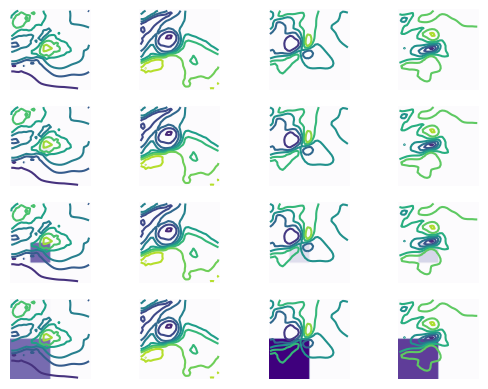

In [ ]:
bands = X[0].shape[-1]
n_maps = len(occmaps)

fig, axs = plt.subplots(n_maps, bands)

# Use the min & max across all channels for consistent colorbars
vmin = np.min(np.array(occmaps))
vmax = np.max(np.array(occmaps))

for i, occmap in enumerate(occmaps):
  for band in range(bands):
    axs[i, band].contour(X[0,:,:,band])
    axs[i, band].imshow(occmap[:,:,band], origin='lower', cmap="Purples", vmin=vmin, vmax=vmax)
    axs[i, band].set_axis_off()

## Channel-wise PartitionSHAP




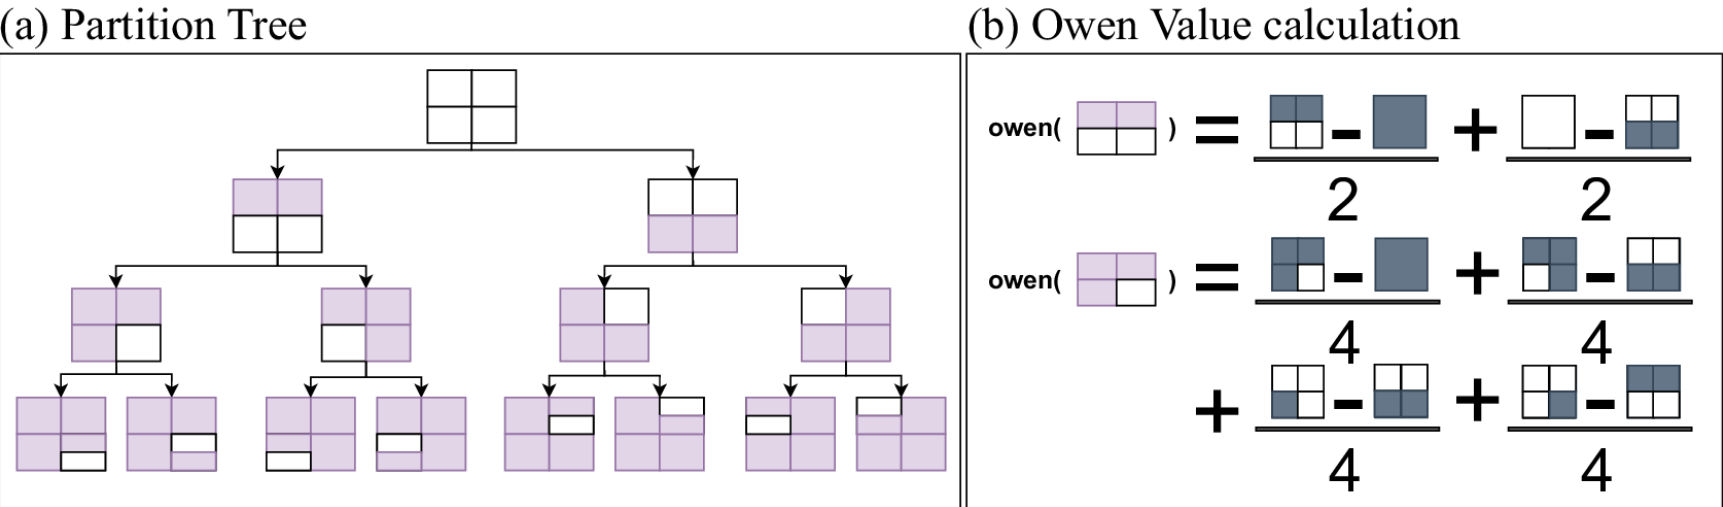

**PartitionSHAP**

- Instead of individual pixels, [PartitionSHAP](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html) takes into consideration the SHAP values of larger superpixels.
- This is done using a hiearchichy of recursively subdividing the input raster into quadrants.
- Since models may learn top use larger image features instead of single pixels, this may provide a better explanation.
- But the division into quadrants means that the superpixels are selected arbitrarily and could miss the actual superpixels used by the model.

**Channel-wise PartitionSHAP (CwPS)**

- PartitionSHAP was designed for RBG/grayscale images
- We want to do it to each channel
- [Krell et al.](https://www.cambridge.org/core/journals/environmental-data-science/article/aggregation-strategies-to-improve-xai-for-geoscience-models-that-use-correlated-highdimensional-rasters/F6017A23BEF0BD48969225D68DF819A2) modified it to better support multi-channel rasters
- Documentation: [[SHAP library]](https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html)
- Detailed CwPS explanation: [[Krell et al.]](https://www.cambridge.org/core/journals/environmental-data-science/article/aggregation-strategies-to-improve-xai-for-geoscience-models-that-use-correlated-highdimensional-rasters/F6017A23BEF0BD48969225D68DF819A2)

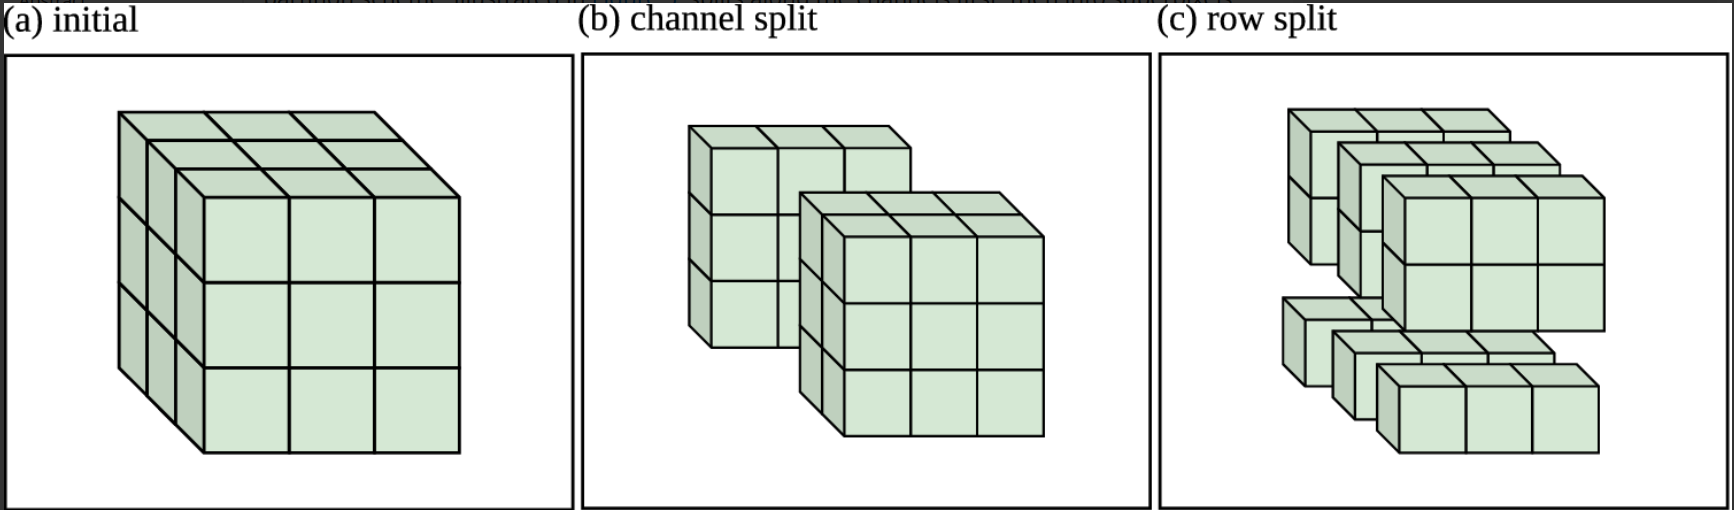

**SHAP value visualization color scheme**

- Red: raster region contributed toward tornadic case
  - Toward higher probability of low-level vorticity exceeding threshold
- Blue: raster region contributed away from tornadic case
  - Toward lower probability of low-level vorticity exceeding threshold

**Each of the following plots is has 3 rows and four columns**

- Columns: the 4 channels (feature maps)
- Rows:
  - row 1: feature map data values
  - row 2: SHAP values, colors relative across all four channels
  - row 3: SHAP values, colors relative to the single channel

**Define SHAP masker**

In [ ]:
# Sample data to get shape
X = best_hits_matrix_norm[0][0:1]

# Masking methods
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
masker_blur_10x10 = shap.maskers.Image("blur(10, 10)", X[0].shape, partition_scheme=1)
masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)

**Define SHAP explainer**

In [ ]:
def explain_multiband(data, masker):
  # Initialize PartitionShap explainer
  explainer = shap.Explainer(m, masker)

  # Explain batch (calculate SHAP values)
  shap_values = explainer(data, max_evals=10000)

  return shap_values

In [ ]:
def plot_storm_xai(values, shap_values):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 4, figsize=(24, 18))

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)

  # Reflectivity
  ax[0][0].set_title("Reflectivity (dbz)")
  ax[0][0].pcolormesh(values[:,:,0],
                      cmap=REFL_COLOUR_MAP_OBJECT,
                      norm=REFL_COLOUR_NORM_OBJECT,
                      vmin=None,
                      vmax=None,
                      shading="flat", edgecolors='None')
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,0])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  ax[0][1].set_title("Temp (k) & wind field")
  ax[0][1].pcolormesh(values[:,:,1],
                      cmap='YlOrRd',
                      norm=None,
                      vmin=min_temp_kelvins,
                      vmax=max_temp_kelvins,
                      shading="flat", edgecolors='None')
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,1])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  ax[0][2].set_title("U-wind (m/s)")
  ax[0][2].pcolormesh(values[:,:,2],
                      cmap='seismic',
                      norm=None,
                      vmin=-1 * max_speed_m_s01,
                      vmax=max_speed_m_s01,
                      shading="flat", edgecolors='None')
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,2])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  ax[0][3].set_title("V-wind (m/s)")
  ax[0][3].pcolormesh(values[:,:,3],
                      cmap='seismic',
                      norm=None,
                      vmin=-1 * max_speed_m_s01,
                      vmax=max_speed_m_s01,
                      shading="flat", edgecolors='None')
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,3])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  plt.tight_layout()

def plot_storm_xai_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_xai(v, s)


### Best Hits

**Explain all samples**

In [ ]:
# Normalized values for the model
X = best_hits_matrix_norm[0]

# Original values for the plot
Xplot = best_hits_matrix_denorm

In [ ]:
# Evaluate CwPS
USE_ONLINE_CACHE = True

if USE_ONLINE_CACHE:
  !wget "https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/ams2024_xai_2_cwpsbesthits.pickle"
  with open('ams2024_xai_2_cwpsbesthits.pickle', 'rb') as handle:
      shap_values = pickle.load(handle)
else:
  shap_values = explain_multiband(X, masker_uniform_0)
  # with open('ams2024_xai_2_cwpsbesthits.pickle', 'wb') as handle:
  #     pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

--2024-01-22 03:47:19--  https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/ams2024_xai_2_cwpsbesthits.pickle
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/ams2024_xai_2_cwpsbesthits.pickle [following]
--2024-01-22 03:47:19--  https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/ams2024_xai_2_cwpsbesthits.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9437137 (9.0M) [application/octet-stream]
Saving to: ‘ams2024_xai_2_cwpsbesthits.pickle’

ams2024_xai_2_cwpsb 100%[===================>]   9.00M  --.-KB/s    in 0

**Local explanations**

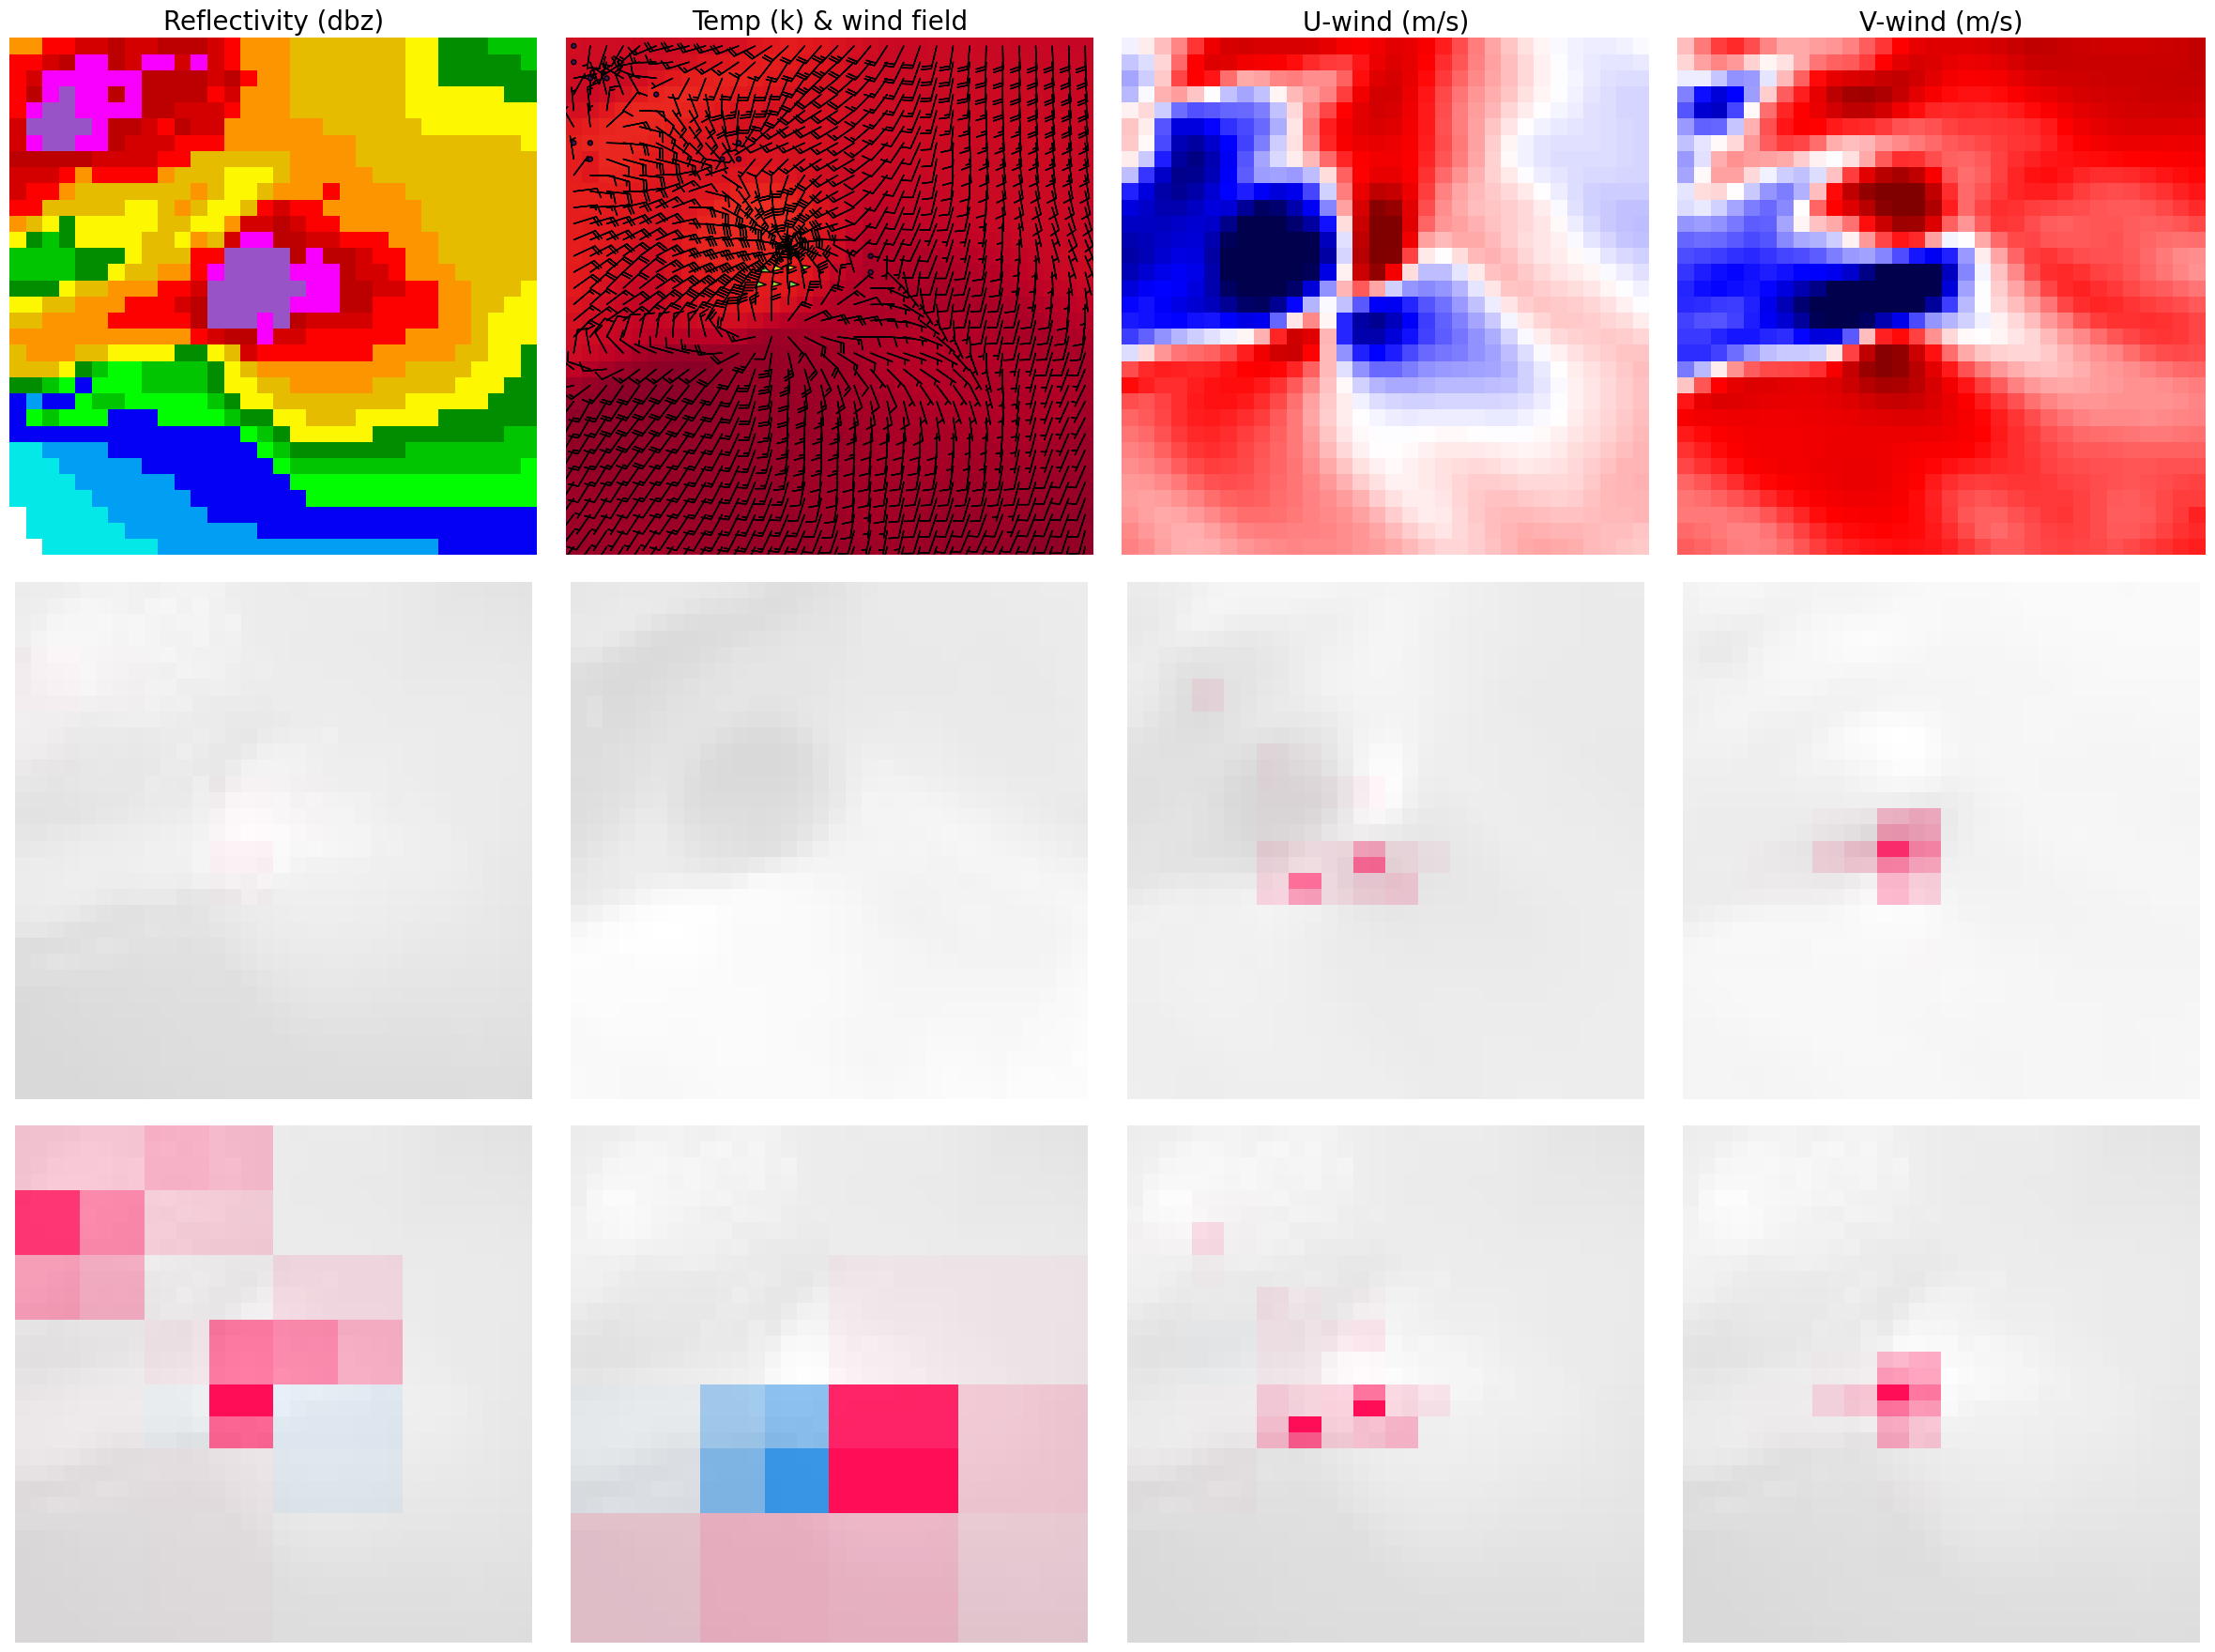

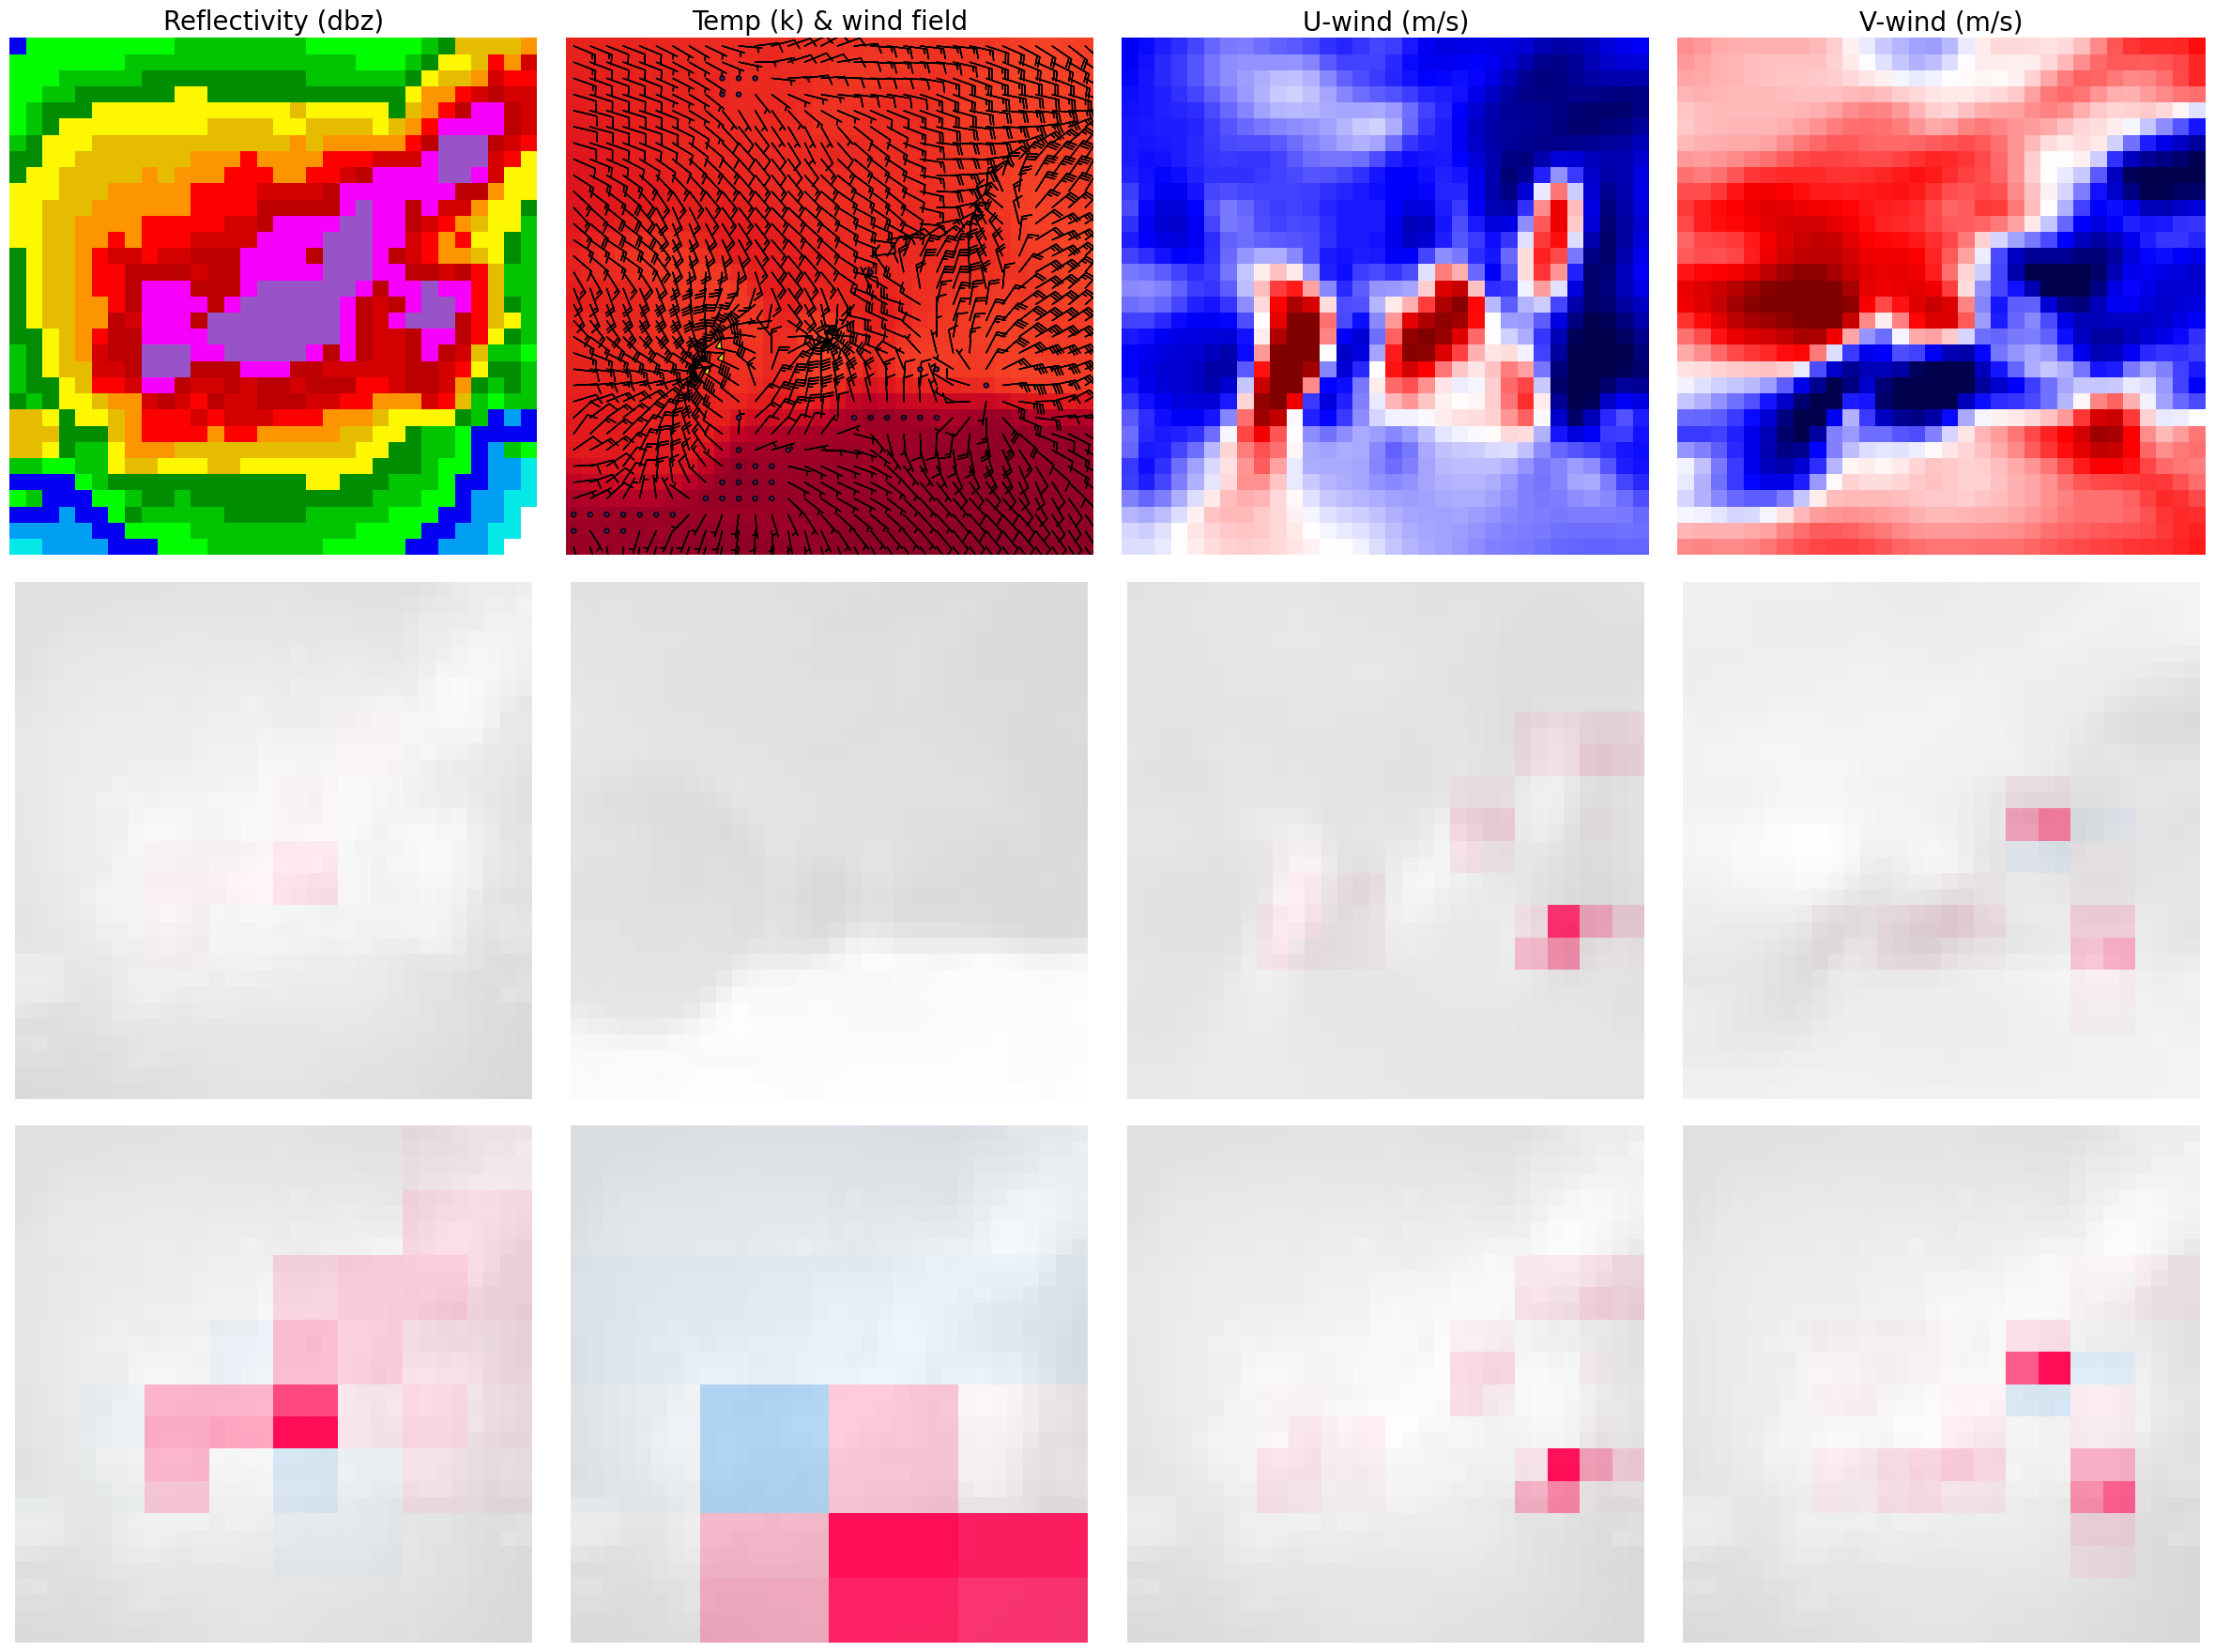

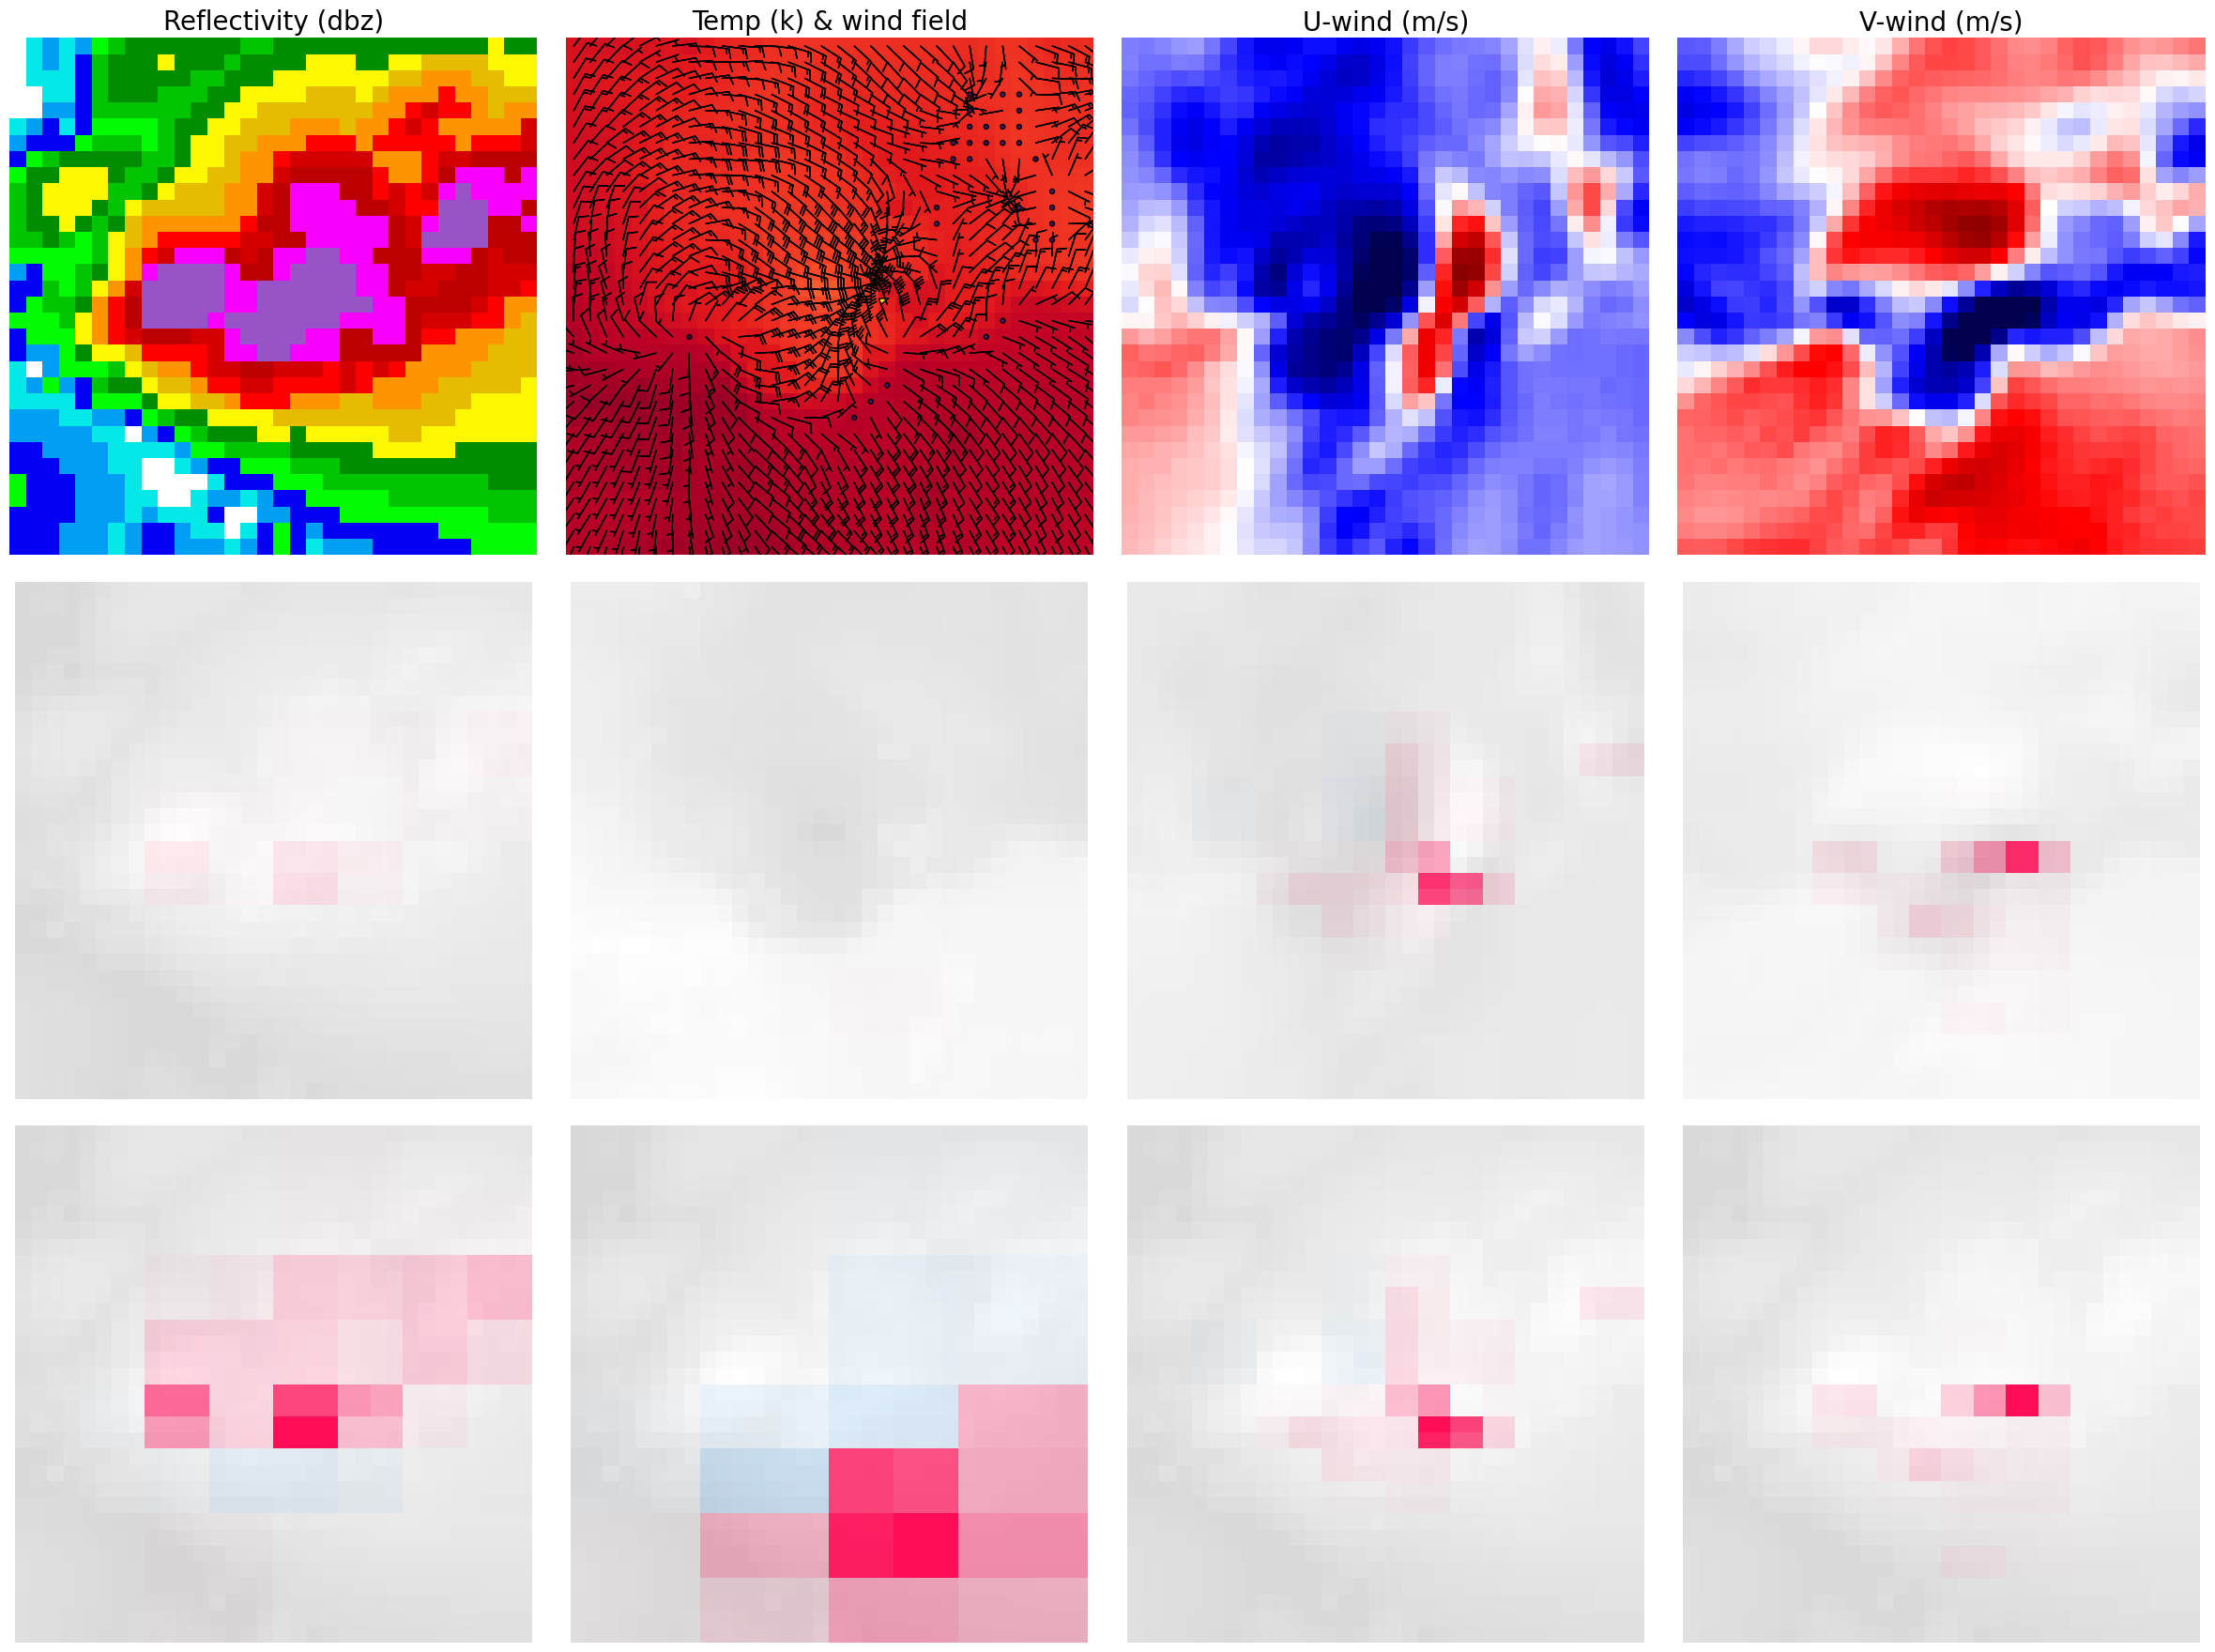

In [ ]:
# Plot first 3 samples
plot_storm_xai_batch(Xplot[0:3], shap_values[0:3].values)

**Aggregate explanation**

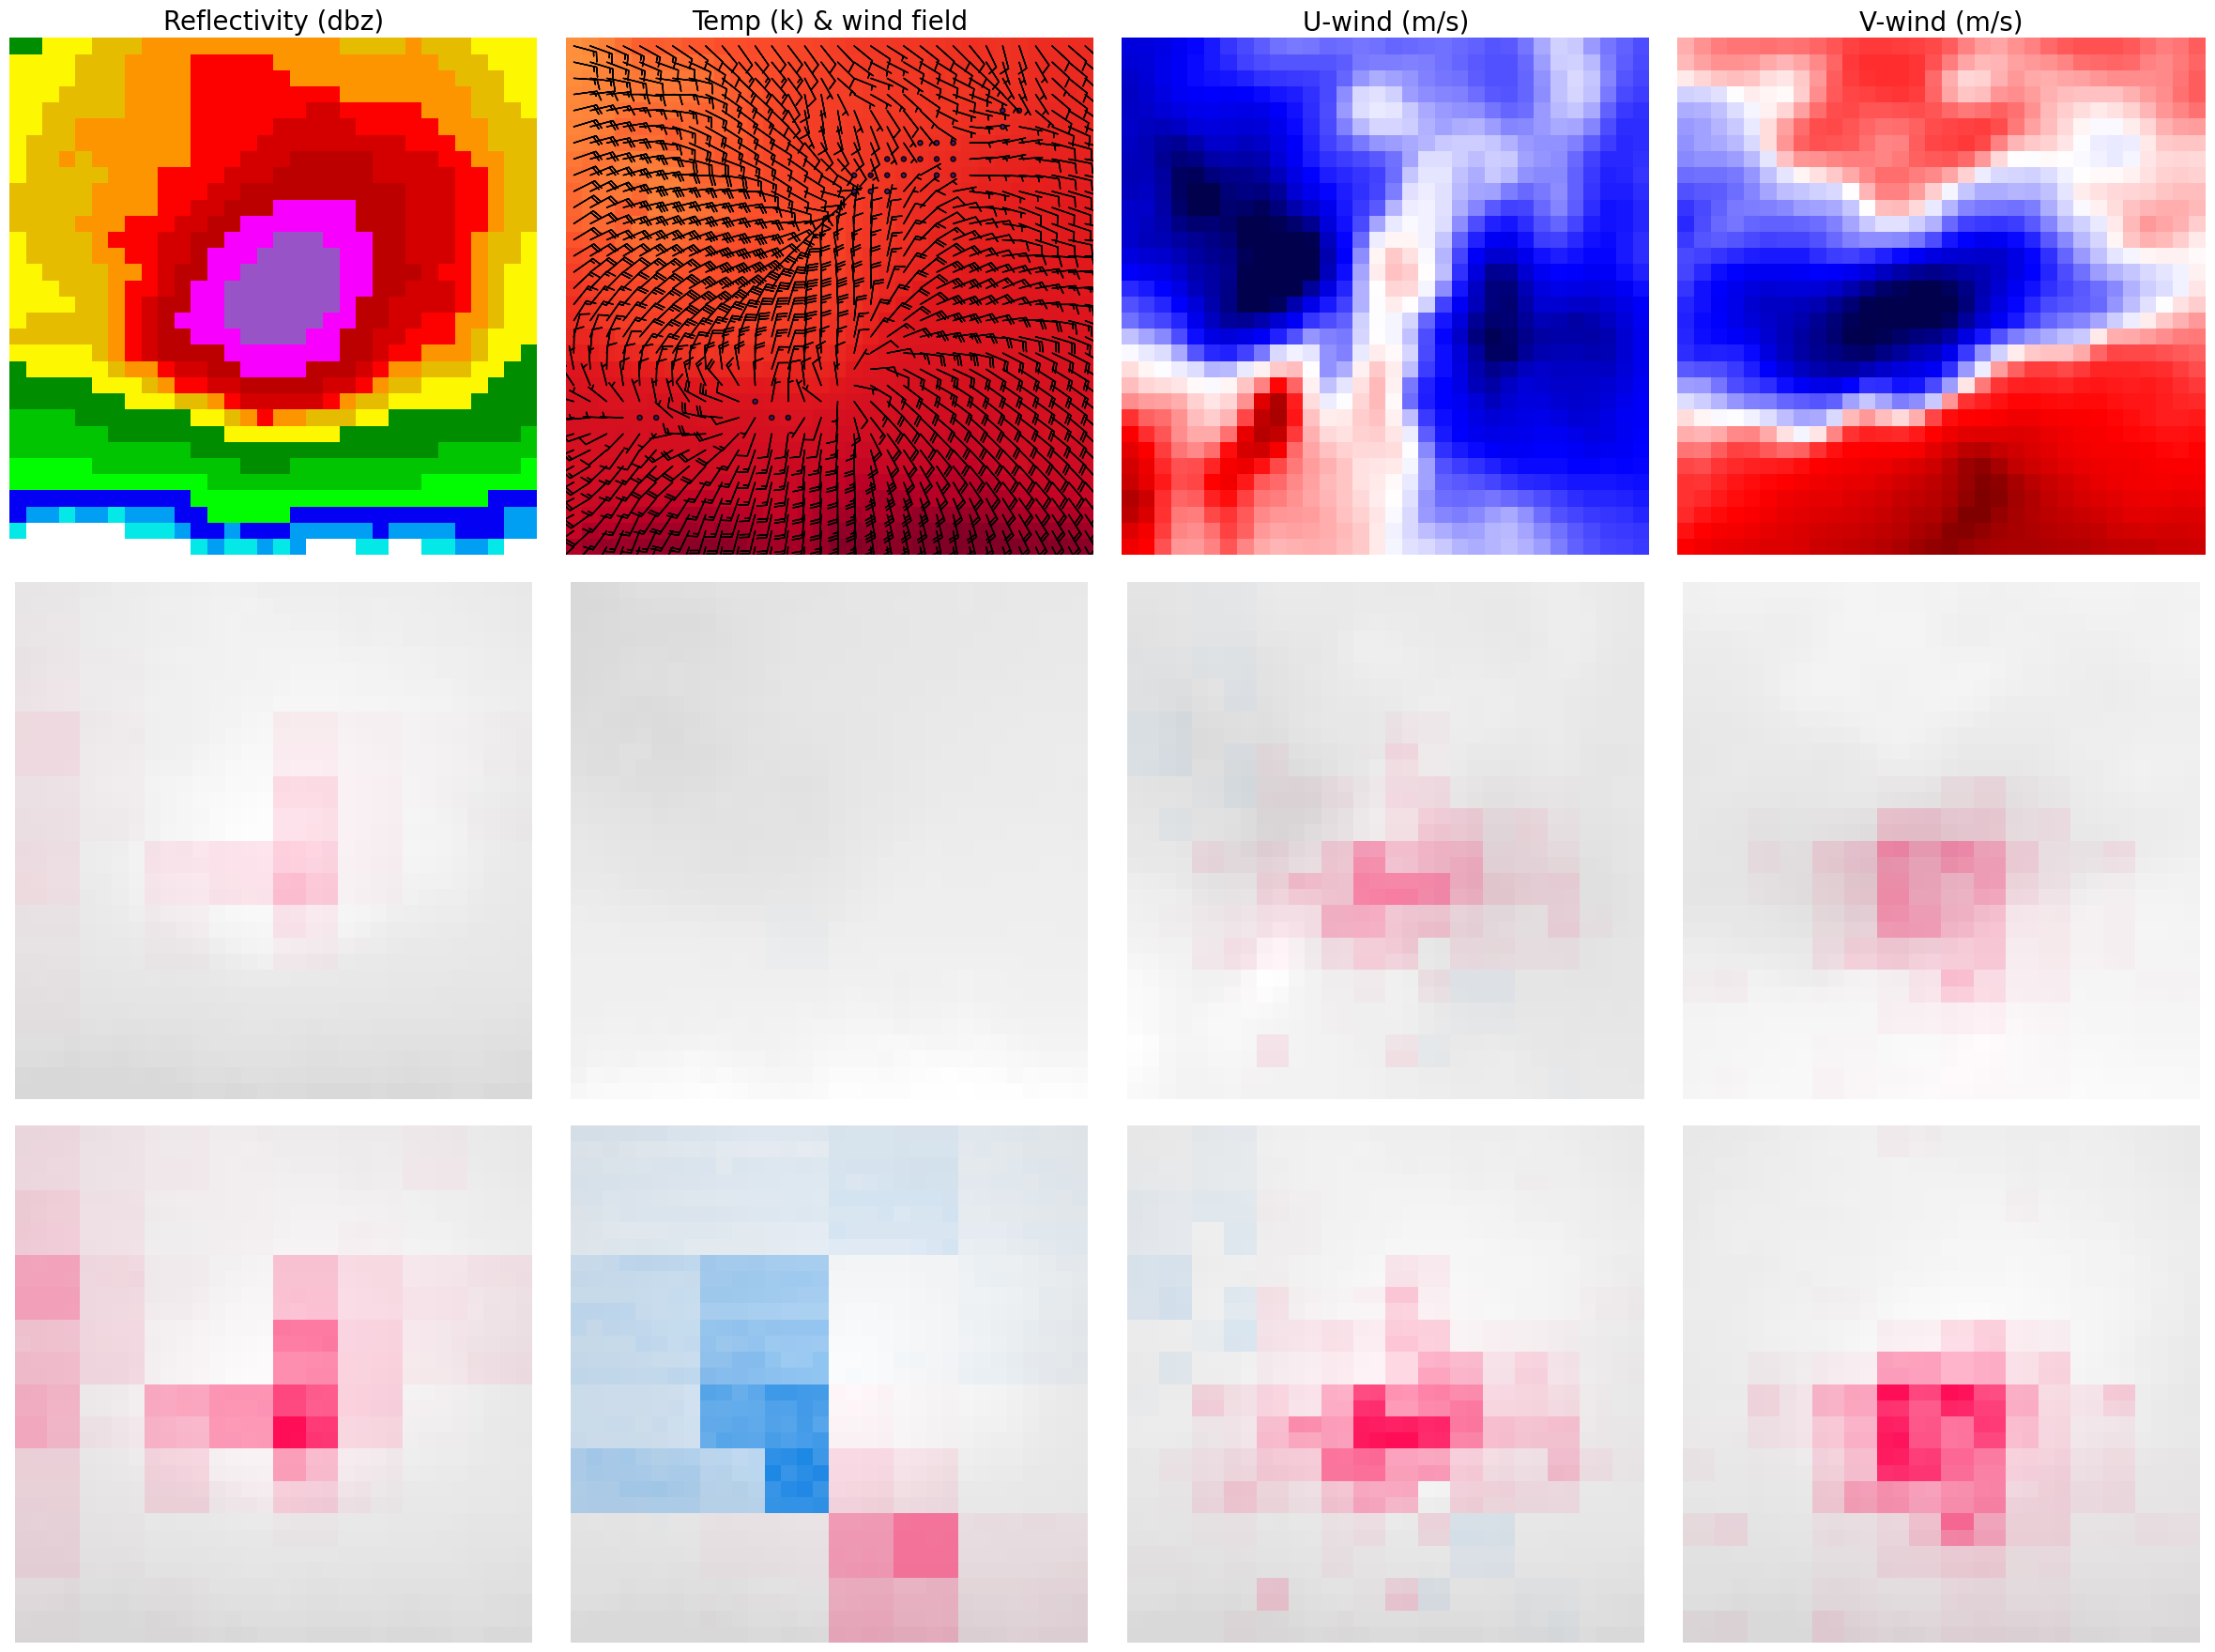

In [ ]:
# Compute a probability-matched means (PMM) summary of the SHAP results
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)

# Plot the batch of aggregate explanations
plot_storm_xai_batch(np.expand_dims(pmm_best_hits_matrix_denorm, axis=0),
                      np.expand_dims(shap_values_pmm, axis=0))

### Worst Misses

**Explain all samples**

In [ ]:
# Normalized values for the model
X = worst_miss_matrix_norm[0]

# Original values for the plot
Xplot = worst_miss_matrix_denorm

In [ ]:
# Evaluate CwPS
USE_ONLINE_CACHE = True

if USE_ONLINE_CACHE:
  !wget "https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/ams2024_xai_2_cwpsworstmisses.pickle"
  with open('ams2024_xai_2_cwpsworstmisses.pickle', 'rb') as handle:
      shap_values = pickle.load(handle)
else:
  shap_values = explain_multiband(X, masker_uniform_0)

with open('ams2024_xai_2_cwpsworstmisses.pickle', 'wb') as handle:
      pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

--2024-01-22 03:47:28--  https://github.com/ekrell/ams_ai_shortcourse_2024/raw/main/data/ams2024_xai_2_cwpsworstmisses.pickle
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/ams2024_xai_2_cwpsworstmisses.pickle [following]
--2024-01-22 03:47:28--  https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/main/data/ams2024_xai_2_cwpsworstmisses.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9437301 (9.0M) [application/octet-stream]
Saving to: ‘ams2024_xai_2_cwpsworstmisses.pickle’

ams2024_xai_2_cwpsw 100%[===================>]   9.00M  --.-

**Local explanations**

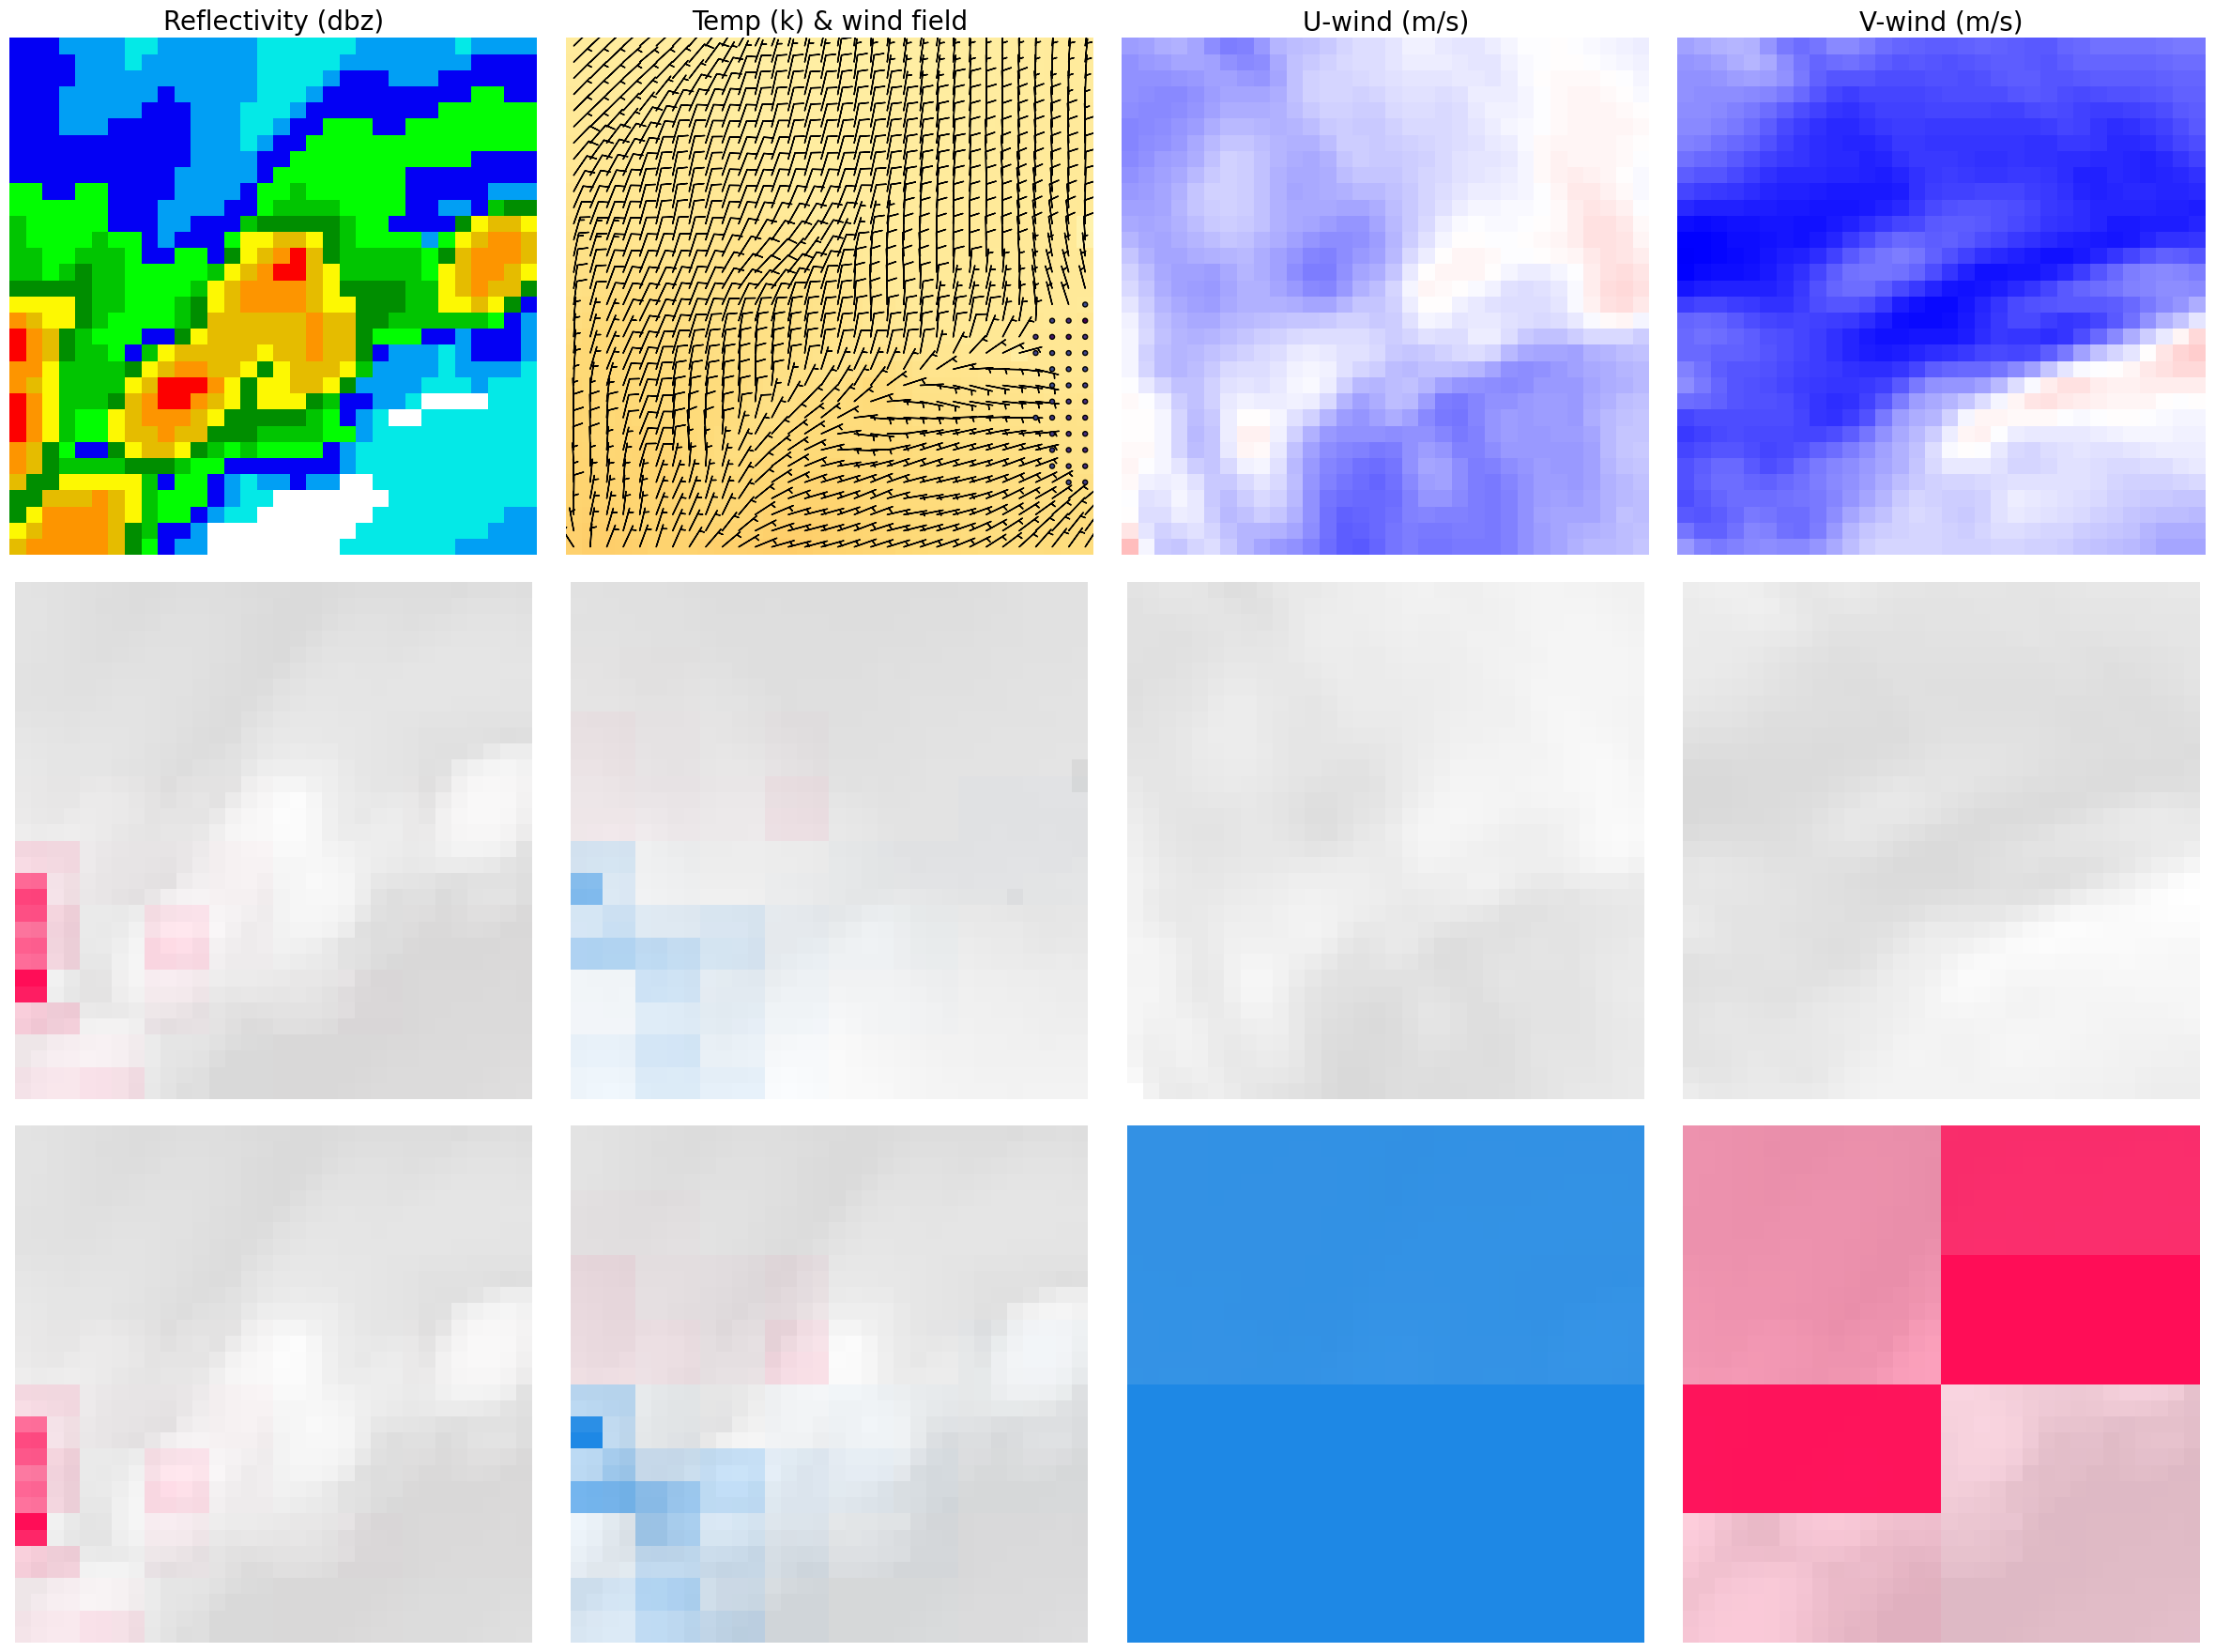

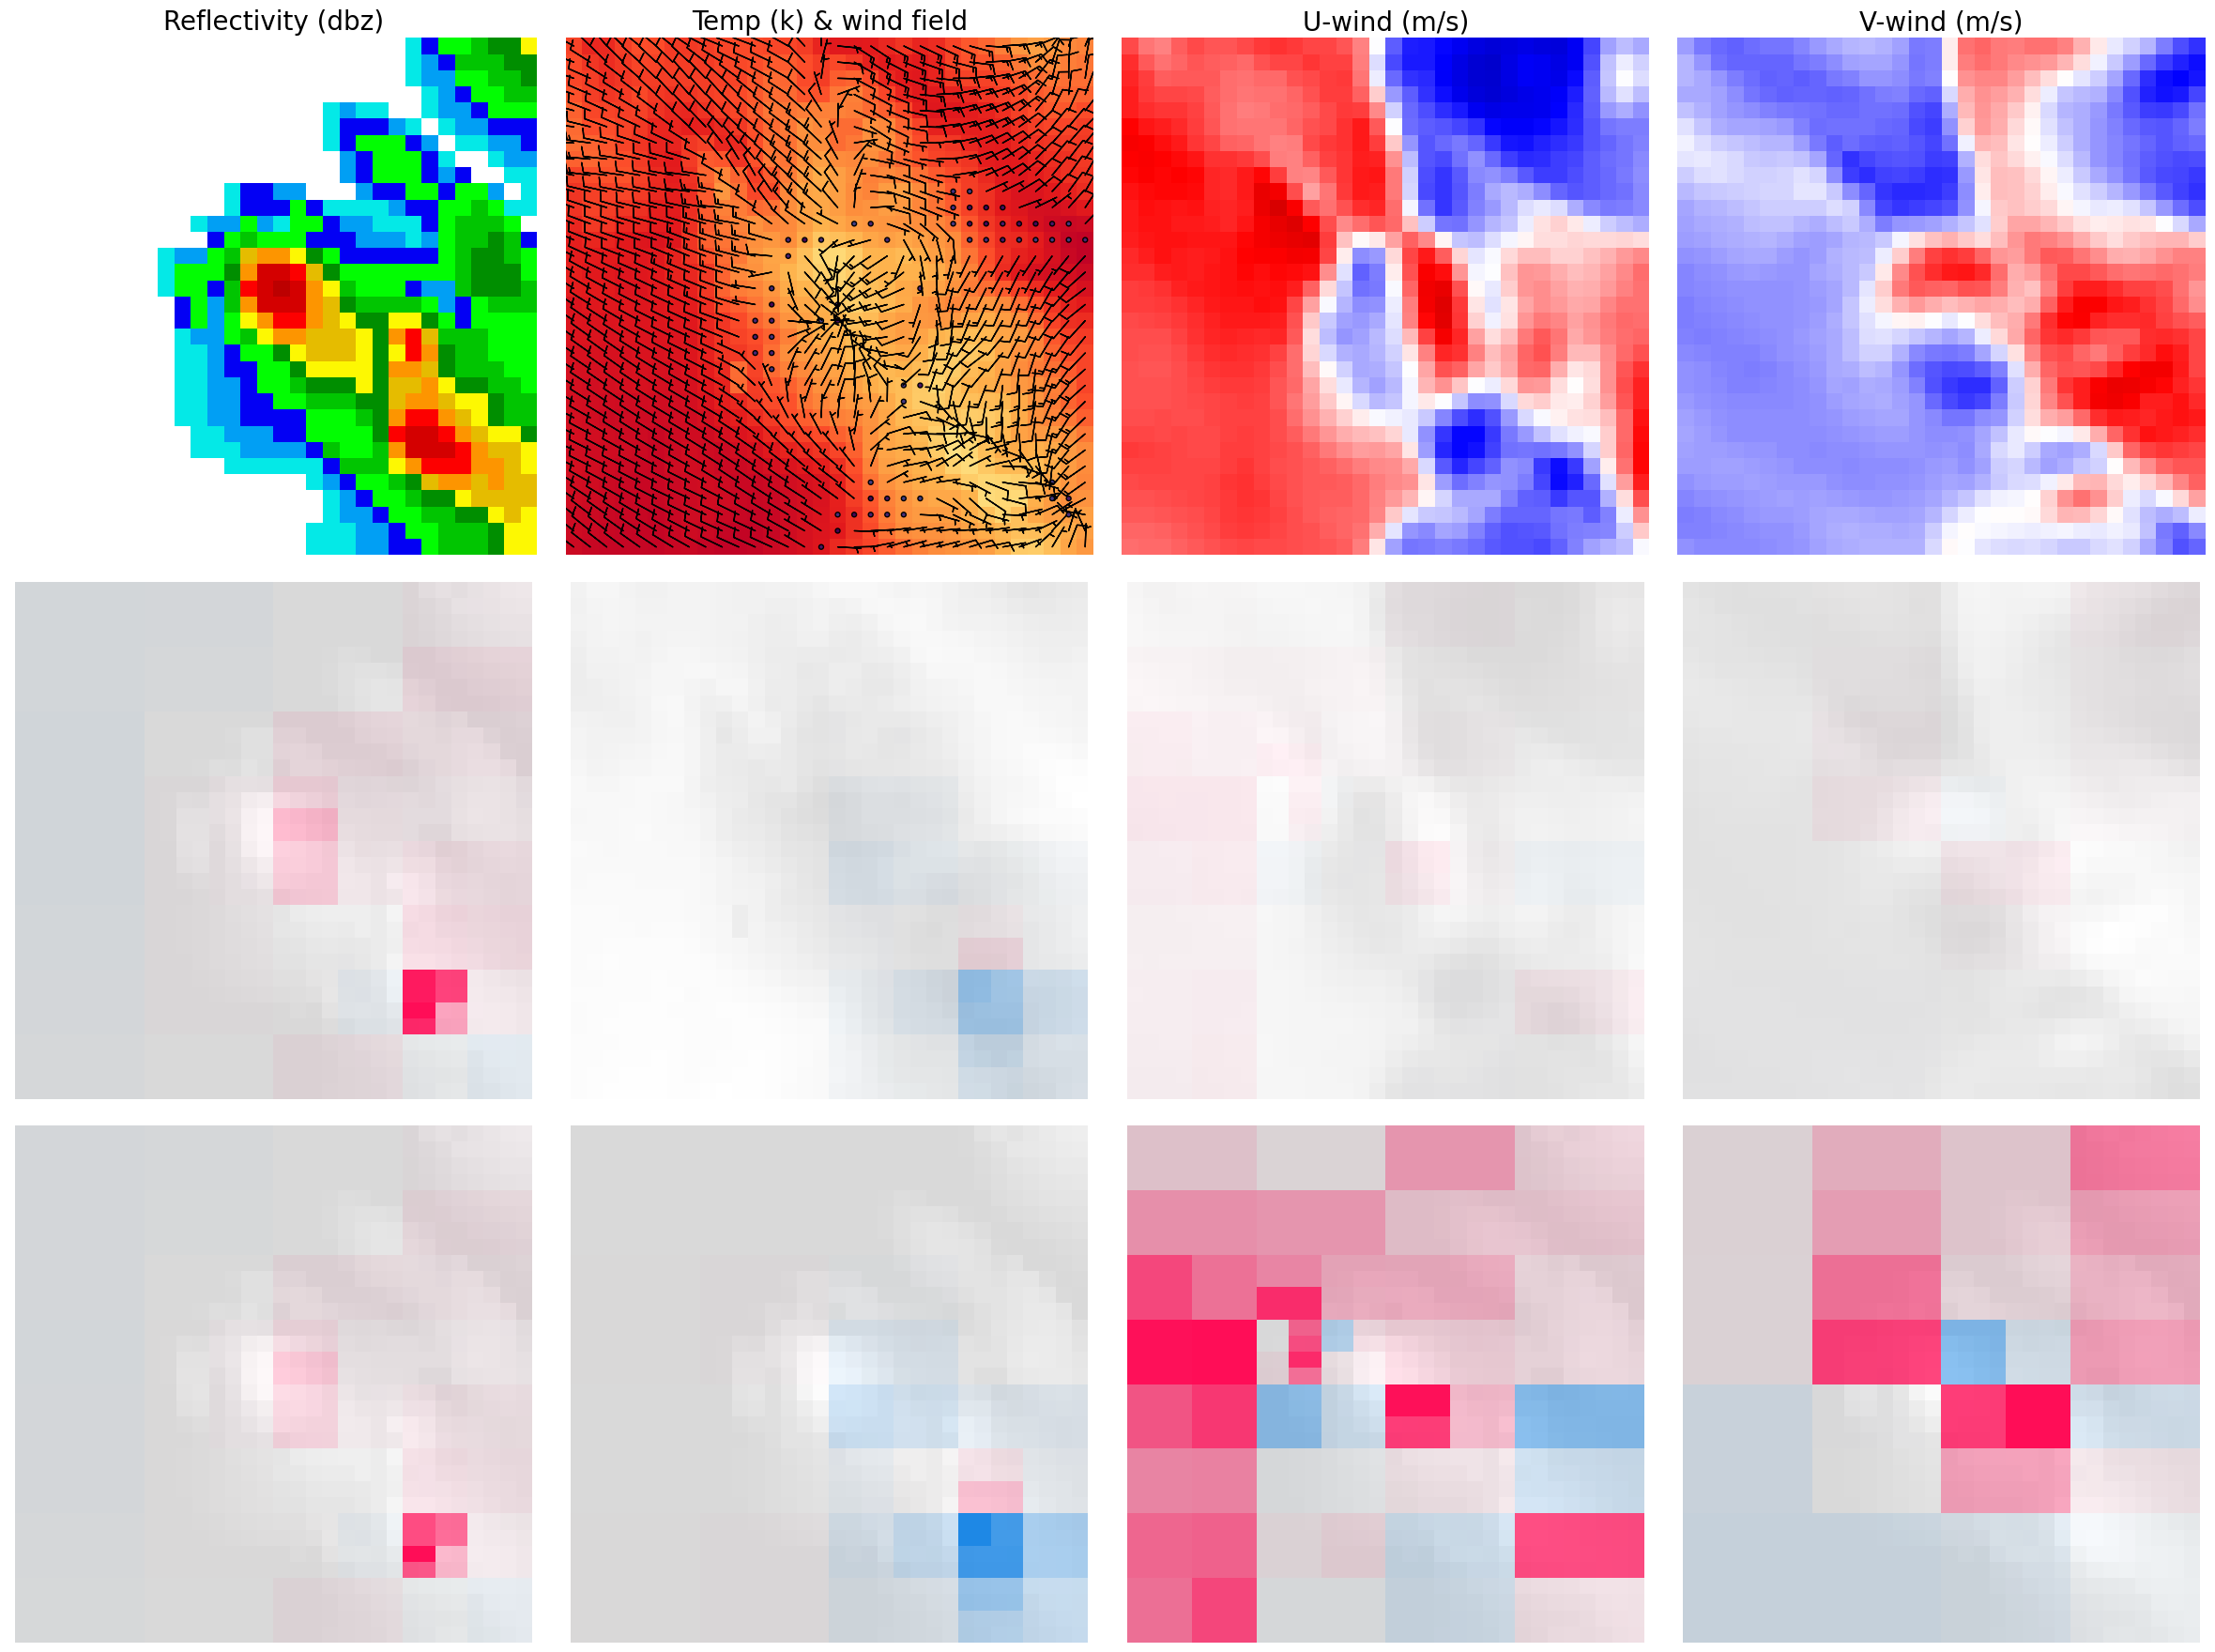

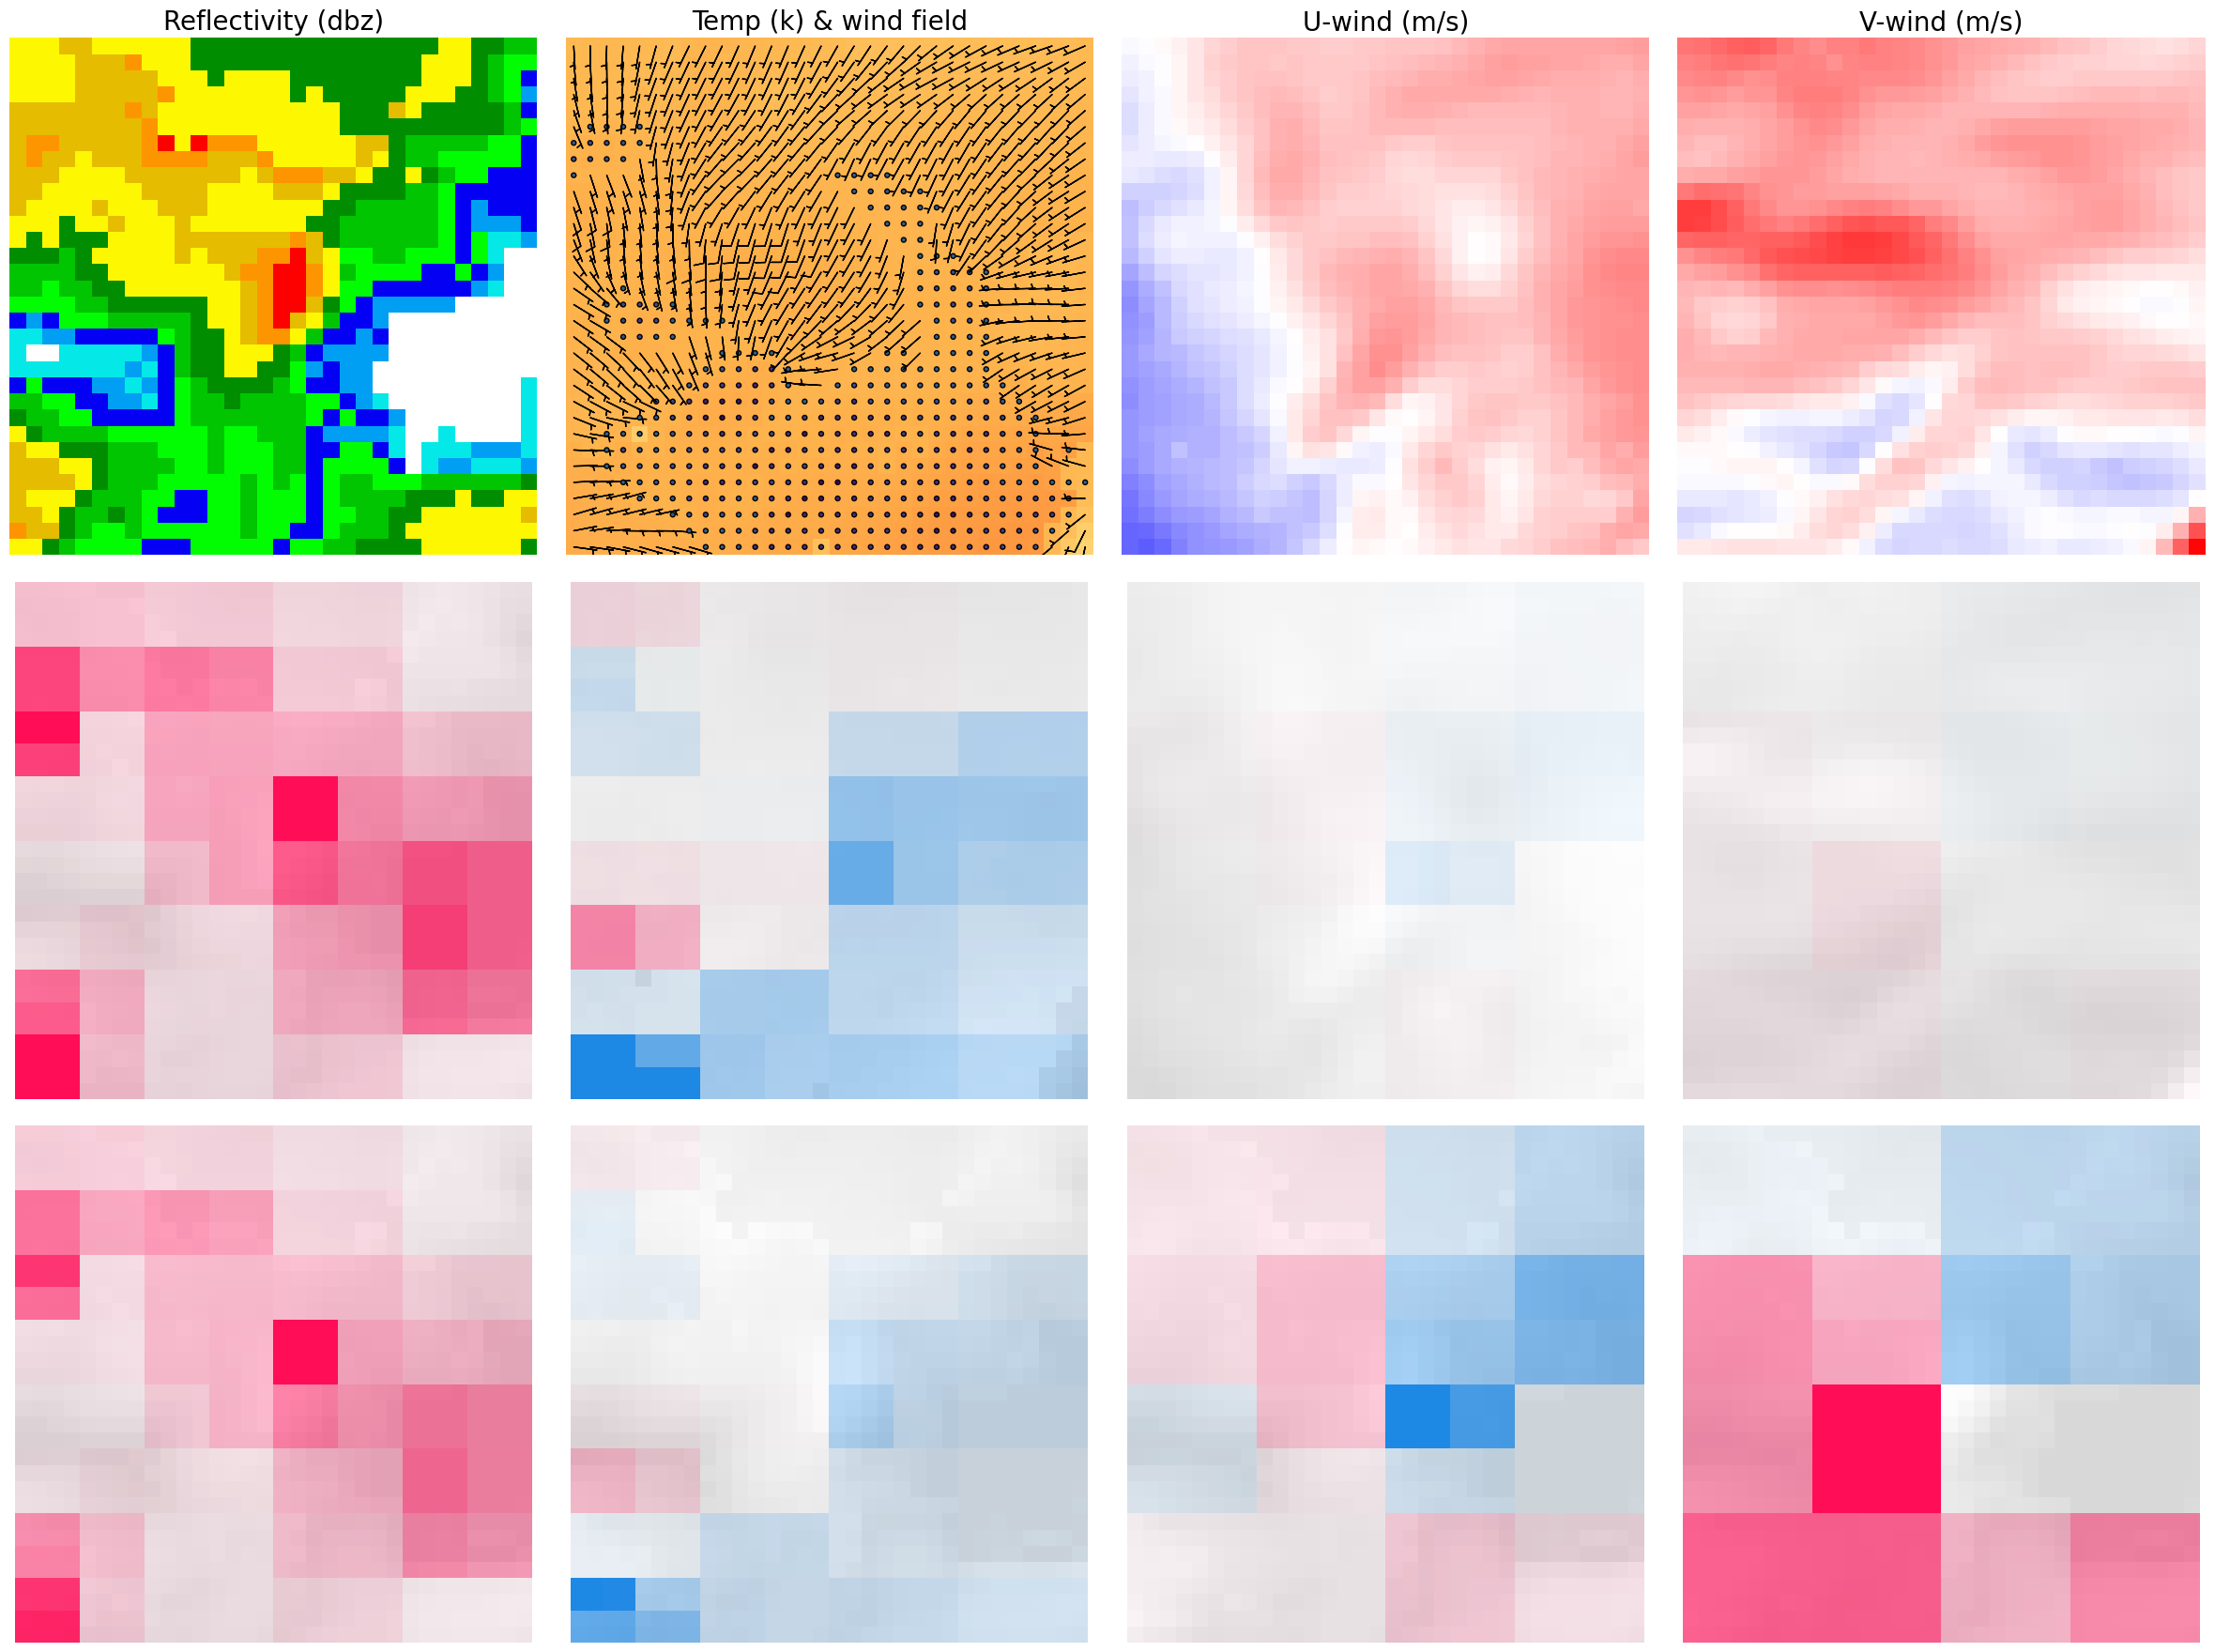

In [ ]:
# Plot first 3 samples
plot_storm_xai_batch(Xplot[0:3], shap_values[0:3].values)

**Aggregate explanation**

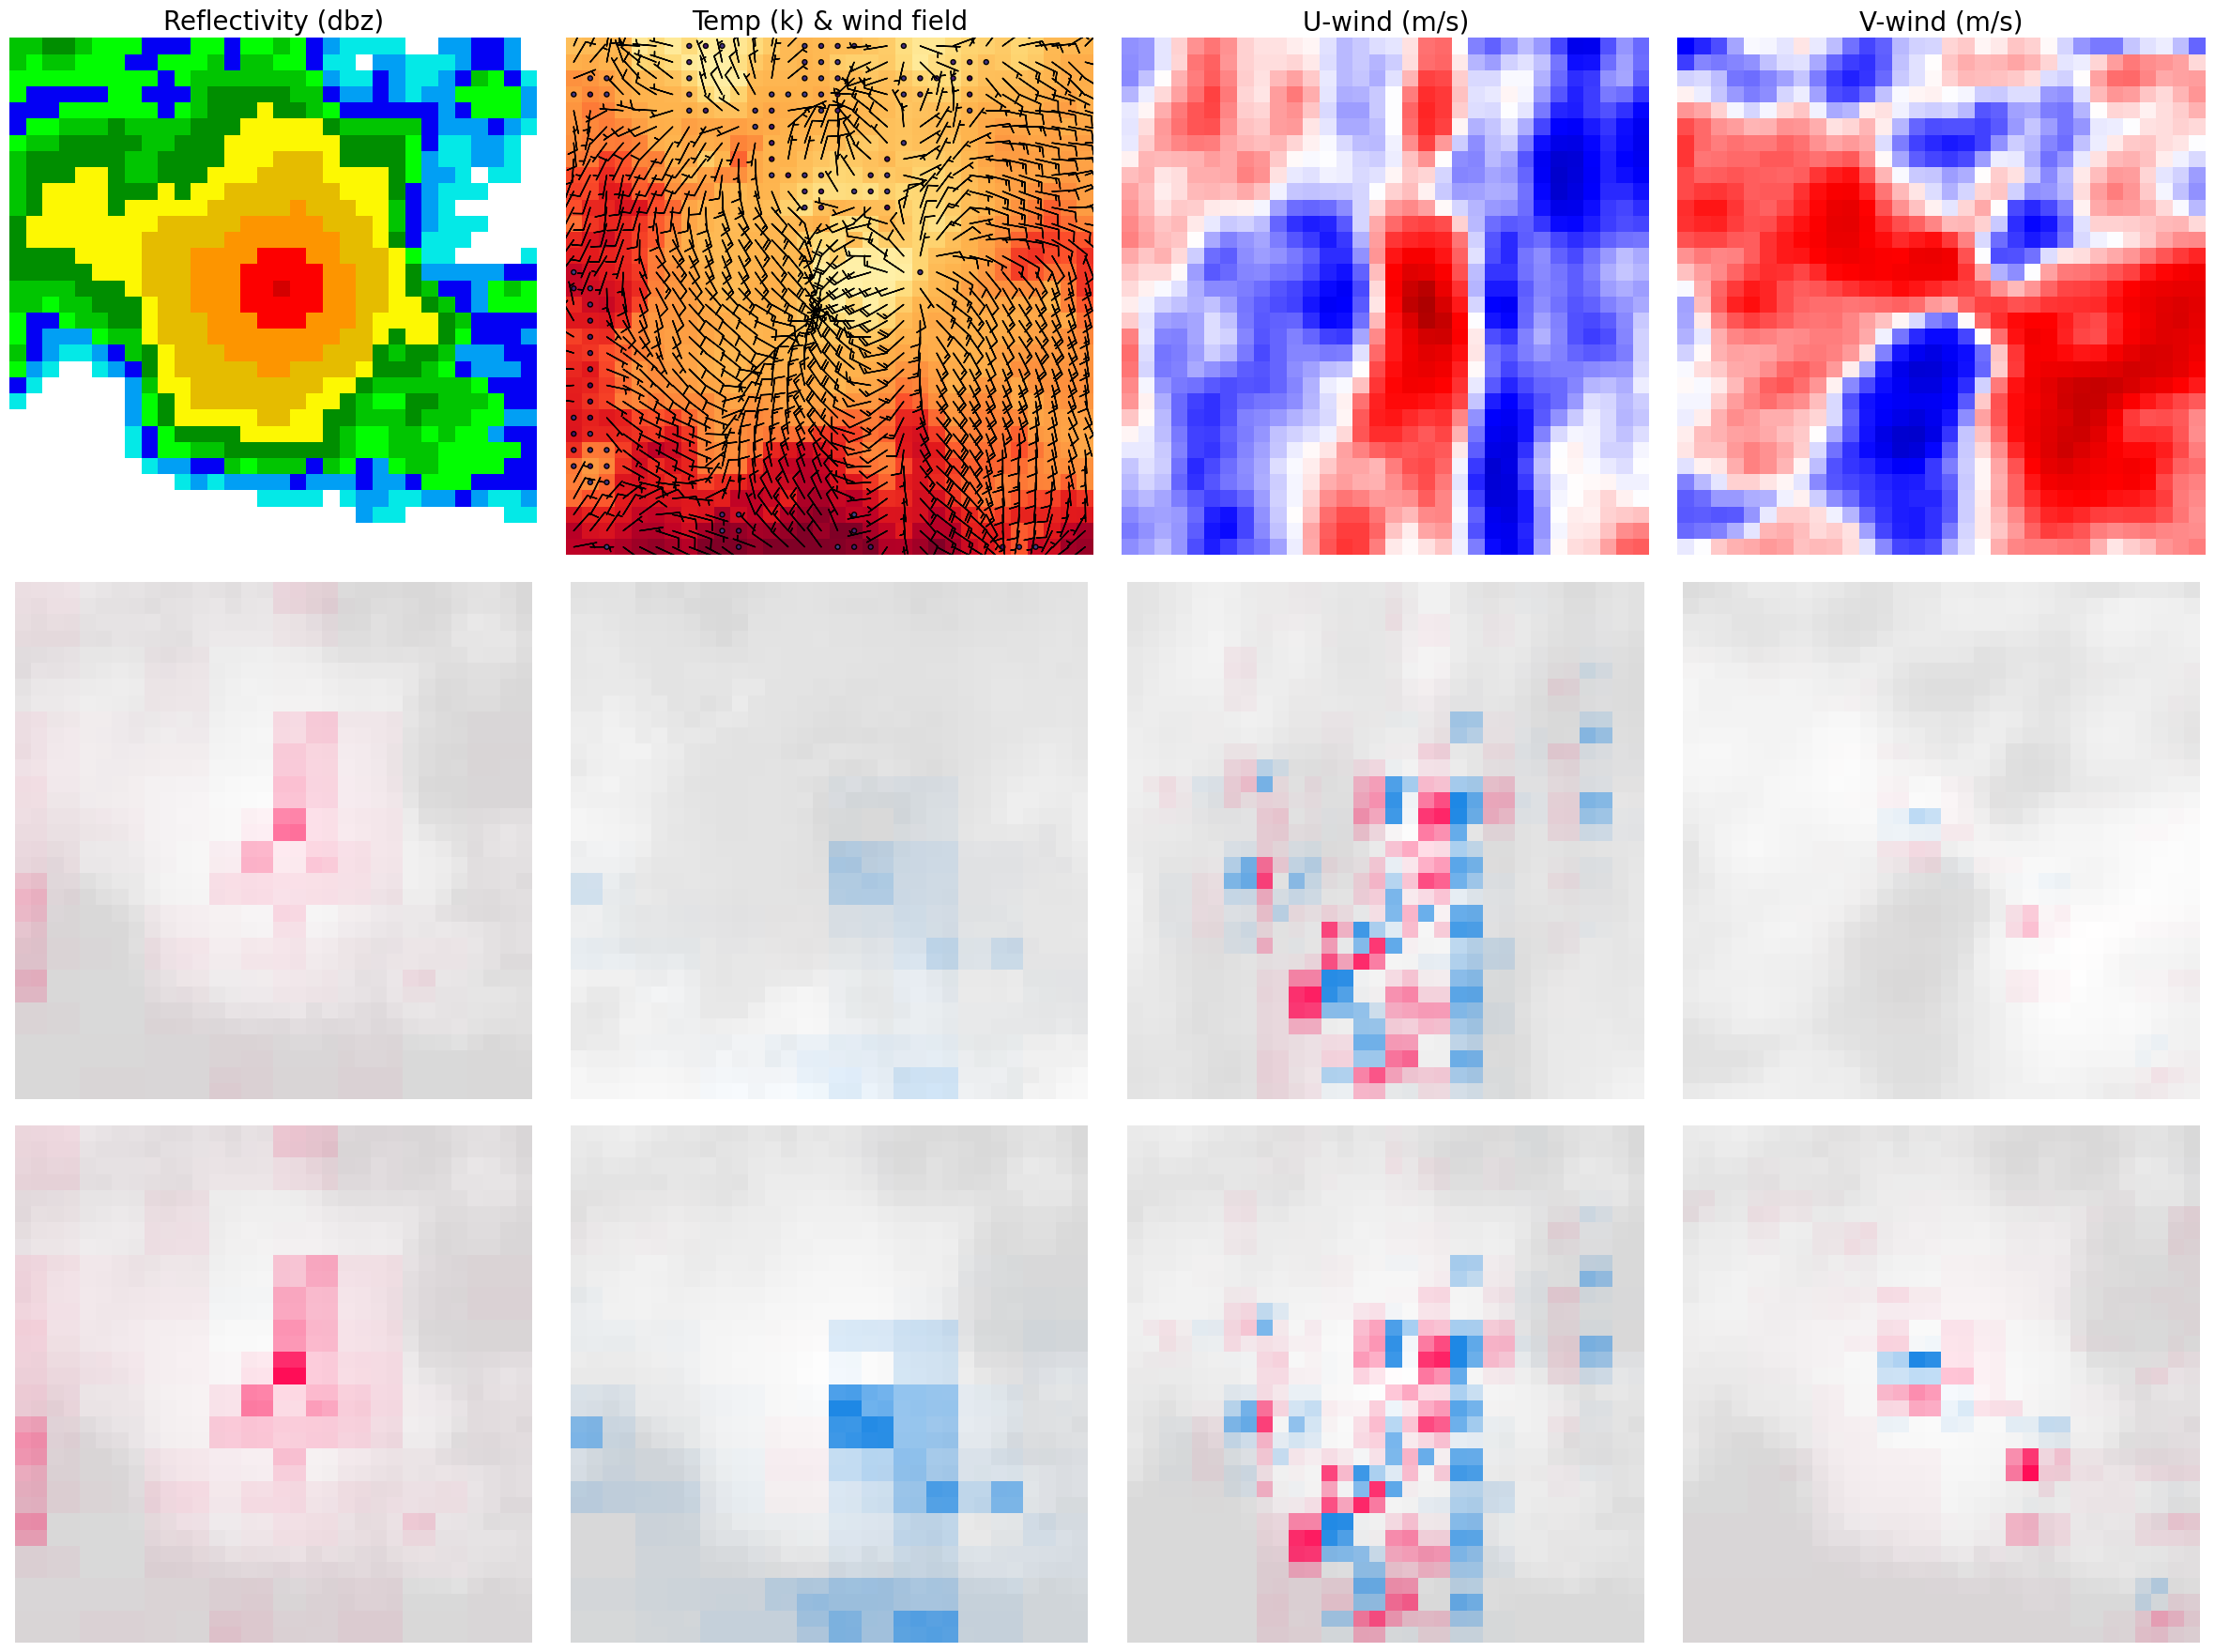

In [ ]:
# Compute a probability-matched means (PMM) summary of the SHAP results
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)

# Plot the batch of aggregate explanations
plot_storm_xai_batch(np.expand_dims(pmm_worst_miss_matrix_denorm, axis=0),
                      np.expand_dims(shap_values_pmm, axis=0))

# Exercise: Sensitivity to Replacement Technique

In a previous code cell, three `maskers` are defined, but only one (`masker_uniform_0`) was used.

1. `masker_uniform_0`: replace cells with value `0`
2. `masker_blur_10x10`: replace cells by blurring with a 10x10 Gaussian blur kernel
3. `masker_blur_32x32`: replace cells by blurring with a 32x32 Gaussian blur kernel

Re-run the CwPS code cells, but using the other 2 maskers. Save the output of each to create a graphic that compares the CwPS explanations when using all three maskers.

How does the choice of replacement technique influence the CwPS results?